<a href="https://colab.research.google.com/github/astrodeepnet/vae_mpoe/blob/main/VAE_HSC_interp_PEGASE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [136]:
from google.colab import drive
drive.mount('/content/drive/')

beta = 0.01
epochs = 20

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


col_SB_10_Kroupa_0.1_120_LR.cat  SB_1_Kroupa_0.1_120_LR.fits
col_SB_1_Kroupa_0.1_120_LR.cat	 SB_2_Kroupa_0.1_120_LR.fits
col_SB_2_Kroupa_0.1_120_LR.cat	 SB_3_Kroupa_0.1_120_LR.fits
col_SB_3_Kroupa_0.1_120_LR.cat	 SB_4_Kroupa_0.1_120_LR.fits
col_SB_4_Kroupa_0.1_120_LR.cat	 SB_5_Kroupa_0.1_120_LR.fits
col_SB_5_Kroupa_0.1_120_LR.cat	 SB_6_Kroupa_0.1_120_LR.fits
col_SB_6_Kroupa_0.1_120_LR.cat	 SB_7_Kroupa_0.1_120_LR.fits
col_SB_7_Kroupa_0.1_120_LR.cat	 SB_8_Kroupa_0.1_120_LR.fits
col_SB_8_Kroupa_0.1_120_LR.cat	 SB_9_Kroupa_0.1_120_LR.fits
col_SB_9_Kroupa_0.1_120_LR.cat	 SSP_Kroupa_0.1_120_LR_broadband_fluxes.fits
makeit.sh			 write_colcube.pro
SB_10_Kroupa_0.1_120_LR.fits
[   30.    50.   100.   200.   300.   500.   800.  1000.  1500.  2000.
  3000.  4000.  5000.  6000.  7000.  8000.  9000. 10000. 11000. 12000.
 13000. 14000. 16000. 18000. 20000.]


<ipython-input-137-863c7ea474a2>:12: RuntimeWarning: divide by zero encountered in log10
  plt.pcolor(np.log10(hdulist[0].data))


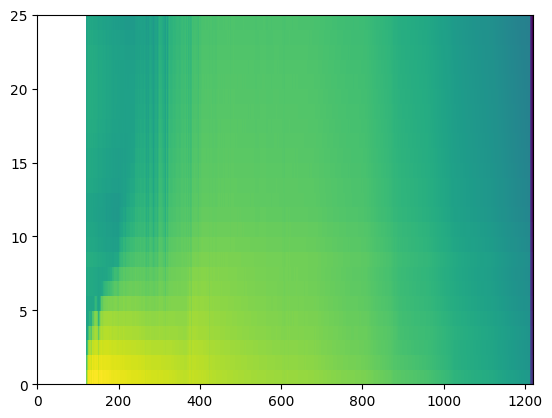

In [137]:
!ls '/content/drive/My Drive/newgrid2_lr_kroupa'

from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

hdulist = fits.open('/content/drive/My Drive/newgrid2_lr_kroupa/SB_6_Kroupa_0.1_120_LR.fits')
np.log10(hdulist['ETS_PARA'].data['ZSTARS'] / 0.02)

print(hdulist['ETS_PARA'].data['AGE'])

plt.pcolor(np.log10(hdulist[0].data))
plt.show()



In [138]:
def fetch_filter_data(filters):
    filter_dict = {}

    for name, filepath in filters:
        try:
            with open(filepath, 'r') as file:
                wavelength, transmission = [], []

                for line in file:
                    parts = line.strip().split()
                    if len(parts) == 2:
                        try:
                            wavelength.append(float(parts[0]))
                            transmission.append(float(parts[1]))
                        except ValueError:
                            continue  # Skip malformed lines

                filter_dict[name] = {
                    "wl": wavelength,
                    "tr": transmission
                }
        except FileNotFoundError:
            print(f"File not found for {name}: {filepath}")
        except Exception as e:
            print(f"Error reading file for {name}: {e}")

    return filter_dict

# Example local filter file paths
filters = [
    ['HSCg', '/content/drive/My Drive/HSC_bands/HSC.g_filter.dat'],
    ['HSCr', '/content/drive/My Drive/HSC_bands/HSC.r_filter.dat'],
    ['HSCi', '/content/drive/My Drive/HSC_bands/HSC.i_filter.dat'],
    ['HSCz', '/content/drive/My Drive/HSC_bands/HSC.z_filter.dat'],
    ['HSCY', '/content/drive/My Drive/HSC_bands/HSC.Y_filter.dat']
]

filer_names = [name for name, _ in filters]

filter_data = fetch_filter_data(filters)



In [139]:
import os
import os
import glob
import numpy as np
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import requests
from scipy.interpolate import interp1d

spec_points = 100
spec_range = (3900, 10200)

def bin_spectrum(spec, wl, spec_range, spec_points):
    min_wl, max_wl = spec_range
    bins = np.linspace(min_wl, max_wl, spec_points + 1)
    mean_values = []
    wl_values = []

    for i in range(len(bins) - 1):
        bin_mask = (wl >= bins[i]) & (wl < bins[i+1])
        bin_data = spec[bin_mask]
        mean_values.append(bin_data.mean() if bin_data.size > 0 else (bins[i] + bins[i+1]) / 2)
        wl_values.append(0.5*(bins[i] + bins[i+1]))
    return np.array(mean_values), np.array(wl_values)


def get_waves(hdr):
     waves = hdr['CRVAL1'] - (hdr['CRPIX1']-1.0)*hdr['CDELT1'] + ( np.arange(0., hdr['NAXIS1']) ) * hdr['CDELT1']
     ran = [waves[0], waves[-1]]
     return waves



def read_fits_files(directory):
    # Define the file pattern to match
    file_pattern = os.path.join(directory, "SB_?_Kroupa_0.1_120_LR.fits")
    fits_files = glob.glob(file_pattern)

    all_spectra = []
    all_params = []

    for fits_file in fits_files:
        with fits.open(fits_file) as hdul:
            spectra = hdul[0].data  # Extracting spectral data
            params = hdul[1].data  # Extracting table data
            wl = get_waves(hdul[0].header)
            all_spectra.extend(spectra*wl**2)
            all_params.append(np.array([tuple(row) for row in params]))  # Ensure structured array consistency

    # Stack spectra along a new axis if necessary (e.g., assuming same dimensions)
    stacked_spectra = np.array(all_spectra)  # Convert list to numpy array

    # Convert list of structured arrays into a single structured array
    structured_params = np.concatenate(all_params) if all_params else None

    # Create an Astropy Table
    result_table = Table(rows=structured_params, names=params.names)

    wl = get_waves(hdul[0].header)
    return stacked_spectra, result_table, wl

# Example usage
#directory = "/content/drive/My Drive/EMILES/"  # Change to the directory containing your FITS files
#spectra, param_table, wl = read_fits_files(directory)


In [140]:
import numpy as np
import glob
from astropy.io import fits
from scipy import interpolate

def read_fits_files(pattern="SB_*_Kroupa_0.1_120_LR.fits"):
    """Reads FITS files and constructs a 3D spectral array."""

    files = sorted(glob.glob(pattern))  # Get all relevant FITS files
    if not files:
        raise FileNotFoundError("No FITS files found matching pattern.")

    spectra_list = []
    ages = []
    mets = []

    for file in files:
        with fits.open(file) as hdul:
            primary_data = hdul[0].data  # Spectra
            params = hdul["ETS_PARA"].data  # Age & metallicity
            wl = hdul[3].data['BFIT']  # Wavelengths
            primary_data = np.array([fl*wl**2 for fl in primary_data])
            age = params["AGE"]  # Extract age
            met = params["ZSTARS"]  # Extract metallicity
            spectra_list.append(primary_data[age > 100])
            ages.append(np.log10(age)[age > 100])
            mets.append(np.round(np.log10(met/0.02), 2)[age > 100])

    spectra_array = np.stack(spectra_list, axis=1)  # Convert list to 3D array

    # Convert age and metallicity into logarithmic scales divided by 0.2
    lages = np.array(ages)
    lmets = np.array(mets)

    return lages, lmets, spectra_array, wl

class SpectrumInterpolator:
    def __init__(self, lages, lmets, flx):
        """Initialize with log(age), log(metallicity), and flux array."""
        self.lages = np.unique(lages)  # Ensure uniqueness
        self.mets = np.unique(lmets)
        self.flx = flx
        print(self.lages.shape, self.mets, flx[:, :, 0].shape)
        # Create interpolators for each wavelength slice
        self.interpolators = [
            interpolate.RectBivariateSpline(self.lages, self.mets, flx[:, :, i])
            for i in range(flx.shape[2])
        ]

    def evaluate(self, age, metallicity):
        """Evaluate spectrum at arbitrary log(age) and log(metallicity)."""
        log_age = np.log10(age)
        log_met = metallicity

        return np.array([interp(log_age, log_met)[0, 0] for interp in self.interpolators])

# Usage Example
lages, lmets, flx, wl = read_fits_files('/content/drive/My Drive/newgrid2_lr_kroupa/SB_*_Kroupa_0.1_120_LR.fits')
spectrum_interp = SpectrumInterpolator(lages, lmets, flx)

# Evaluate spectrum at specific age and metallicity
age_sample = 1100  # Example age (5 Gyr)
met_sample = -0.50  # Example metallicity

def calc_spec(wl, age = 1000, met = 0.00, z=0.0):
    spec = spectrum_interp.evaluate(age, met)
    return (spec, wl*(1 + z))


'''
def calc_spec(spectra, param_table, wl, age = 1000, met = 0.02, z=0.0):
    da = np.abs(param_table['AGE'] - age)
    dm = np.abs(param_table['ZSTARS']/met - 1)
    idx = np.where((da == np.min(da)) & (dm == np.min(dm)))[0]
    spec = spectra[idx][0]
    return (spec, wl*(1 + z))
'''

(22,) [-2.5 -2.  -1.5 -1.  -0.5 -0.3  0.   0.3  0.5  1. ] (22, 10)


"\ndef calc_spec(spectra, param_table, wl, age = 1000, met = 0.02, z=0.0):\n    da = np.abs(param_table['AGE'] - age)\n    dm = np.abs(param_table['ZSTARS']/met - 1)\n    idx = np.where((da == np.min(da)) & (dm == np.min(dm)))[0]\n    spec = spectra[idx][0]\n    return (spec, wl*(1 + z))\n"

In [141]:
def download_filter_curve(url):
    """Download and parse the filter transmission curve from a given URL."""
    response = requests.get(url)
    response.raise_for_status()
    data = np.loadtxt(response.iter_lines())
    return data[:, 0], data[:, 1]  # wavelengths, transmissions

def calculate_flux_and_mag(spectra_list, wavelengths_list, filters):
    """Calculate the flux and AB magnitude for multiple spectra and filters."""
    all_results = []
    all_speclr = []
    all_wllr = []

    for spectra, wavelengths in zip(spectra_list, wavelengths_list):
        results = []
        speclr, wllr = bin_spectrum(spectra, wavelengths, spec_range, spec_points)
        for filter_name, filter_url in filters:
            #filter_wavelengths, transmissions = download_filter_curve(filter_url)
            fd = filter_data[filter_name]
            filter_wavelengths, transmissions = fd['wl'], fd['tr']
            # Interpolate spectra onto the filter transmission wavelengths
            interp_flux = interp1d(wavelengths, spectra, kind='linear', fill_value=0, bounds_error=False)
            flux_interp = interp_flux(filter_wavelengths)
            filter_wavelengths = np.array(filter_wavelengths)
            # Calculate total flux (assuming simple integration)
            total_flux = np.trapz(flux_interp * transmissions, filter_wavelengths)
            total_flux /= np.trapz(transmissions, filter_wavelengths)
            #total_flux /= np.nanmax(total_flux)

            # Calculate AB magnitude
            if total_flux > 0:
                ab_magnitude = -2.5 * np.log10(total_flux) - 48.6  # AB mag formula
            else:
                ab_magnitude = np.inf  # Undefined magnitude for zero flux

            results.append([filter_name, total_flux, ab_magnitude])

        all_results.append(results)
        all_speclr.append(speclr)
        all_wllr.append(wllr)

    return all_results, [all_speclr, all_wllr]


filters = [
    ['HSCg', '/content/drive/My Drive/HSC_bands/HSC.g_filter.dat'],
    ['HSCr', '/content/drive/My Drive/HSC_bands/HSC.r_filter.dat'],
    ['HSCi', '/content/drive/My Drive/HSC_bands/HSC.i_filter.dat'],
    ['HSCz', '/content/drive/My Drive/HSC_bands/HSC.z_filter.dat'],
    ['HSCY', '/content/drive/My Drive/HSC_bands/HSC.Y_filter.dat']
]

spectra_list = []
wavelengths_list = []

num_samples = 2000  # Adjust as needed
z_vals = np.random.uniform(0, 1.2, num_samples)
age_vals = 10**np.random.uniform(np.log10(100), np.log10(15000), num_samples)
metdex_vals = np.random.uniform(-1.50, 0.1, num_samples)

n_young = int(num_samples/10)

age_young_vals = np.random.uniform(500, 2000, n_young)





spectra_list = []
wavelengths_list = []
param_list = []

for z, age, metdex in zip(z_vals, age_vals, metdex_vals):
    gen = calc_spec(wl, age=age, met=metdex, z=z)
    sp = gen[0]
    if ((age > 7000) & (np.random.random() > 0.7)):
        wei = np.random.random()
        age_add = np.random.uniform(100, 1500)
        gen_add = calc_spec(wl, age=age_add, met=metdex, z=z)
        sp = sp * (1 - wei) + gen_add[0] * wei
        age = age * (1 - wei) + age_add * wei
    sp = sp / np.max(sp)
    spectra_list.append(sp)
    wavelengths_list.append(gen[1])
    param_list.append([z, age, metdex])  # Store the corresponding parameters

print(len(spectra_list))
print(len(wavelengths_list))

mags, lr = calculate_flux_and_mag(spectra_list, wavelengths_list, filters)




output_array = [[[entry[1] for entry in mag_entry], params, speclr] for mag_entry, params, speclr in zip(mags, param_list, lr[0])]

2000
2000


<ipython-input-141-e82fa9d4b763>:26: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_flux = np.trapz(flux_interp * transmissions, filter_wavelengths)
<ipython-input-141-e82fa9d4b763>:27: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_flux /= np.trapz(transmissions, filter_wavelengths)


In [142]:

output_array = [[[float(val) for val in flux_list], [float(params[0]), float(params[1]), params[2]], lr] for flux_list, params, lr in output_array]

print(len(output_array))

N_smpl = 40  # Number of realizations per entry

# Create new array with perturbations
dataset_rnd = []

for flux_list, params, lr in output_array:
    for _ in range(N_smpl):
        perturbed_flux = [val + 0.1 * np.random.normal(0, 1) * val for val in flux_list]  # Add perturbation
        dataset_rnd.append([perturbed_flux, params, lr])  # Duplicate params as required


integrals = np.array([entry[0] / np.max(entry[0]) for entry in dataset_rnd])  # 2D array of flux values
params = np.array([entry[1] for entry in dataset_rnd])  # 2D array of corresponding parameters
params[:, 1] /= 1e4
spectra = np.array([entry[2] / np.max(entry[2]) for entry in dataset_rnd])  # 2D array of corresponding parameters
#spectra = 1e5 * np.array(spectra)


2000


In [143]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import keras
from keras import ops
from keras import layers

import numpy as np
import matplotlib.pyplot as plt



class Sampling(layers.Layer):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon


def build_dense_encoder_sed_branch(input_shape):
    dense_input = keras.Input(shape=input_shape)
#    x = layers.Dense(64, activation='relu')(dense_input)
#    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(dense_input)
    x = layers.Dense(16, activation='relu')(x)
    return keras.Model(dense_input, x, name='dense_encoder_branch')

def build_dense_decoder_sed(latent_dim, output_dim):
    latent_inputs = keras.Input(shape=(latent_dim,), name=f'z_sampling')
    x = layers.Dense(16, activation='relu')(latent_inputs)
    x = layers.Dense(32, activation='relu')(x)
#    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(output_dim, activation='sigmoid')(x)
    return keras.Model(latent_inputs, outputs, name='dense_decoder')

def build_encoder_sp_branch(input_shape):
    cnn_input = keras.Input(shape=input_shape)
    #x = layers.Conv1D(32, 3, activation='relu', strides=2, padding='same')(cnn_input)
    #x = layers.Conv1D(64, 3, activation='relu', strides=2, padding='same')(x)
    #x = layers.Conv1D(128, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Flatten()(cnn_input)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    return keras.Model(cnn_input, x, name='cnn_encoder')

def build_dense_decoder_sp(latent_dim, output_dim):
    latent_inputs = layers.Input(shape=(latent_dim,), name='z_sampling')
    x = layers.Dense(16, activation='relu')(latent_inputs)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    #x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    #x = layers.Dense(256, activation='relu')(x)
    #x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(256, activation='relu')(x)
    outputs = layers.Dense(output_dim[0])(x)
    #outputs = layers.Reshape(output_dim)(x)

    decoder = keras.Model(latent_inputs, outputs, name='dense_decoder')
    return decoder


def corner_plot(r, max_params):
    axs = tuple(range(min(max_params, r[0].shape[1])))  # Ensure indices do not exceed max dimensions
    fig, axes = plt.subplots(len(axs), len(axs), figsize=(10, 10))

    for i, ax_i in enumerate(axs):
        for j, ax_j in enumerate(axs):
            ax = axes[i, j]

            if i == j:
                # Diagonal: 1D histogram
                ax.hist(r[0][:, ax_i], bins=100, color='steelblue', alpha=0.7)
            elif i > j:
                # Lower triangle: 2D histogram
                ax.hist2d(r[0][:, ax_j], r[0][:, ax_i], bins=100, cmap='Blues')
            else:
                # Upper triangle: empty space
                ax.set_visible(False)

            # Remove ticks for clarity
            ax.set_xticks([])
            ax.set_yticks([])

    plt.tight_layout()

In [144]:
class SpectraVAE(keras.Model):
    def __init__(self, input_dim, latent_dim, beta=1, **kwargs):
        super().__init__(**kwargs)
        self.encoder_branch = build_encoder_sp_branch((input_dim,1))

        self.z_mean = layers.Dense(latent_dim, name='z_mean')(self.encoder_branch.output)
        self.z_log_var = layers.Dense(latent_dim, name='z_log_var')(self.encoder_branch.output)

        self.z = Sampling()([self.z_mean, self.z_log_var])

        self.encoder = keras.Model(self.encoder_branch.inputs, [self.z_mean, self.z_log_var, self.z], name='cnn_encoder')

        self.decoder = build_dense_decoder_sp(latent_dim,(input_dim,1))
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.beta = beta
        #super().__init__(inputs=self.encoder.input, outputs=self.decoder.output, **kwargs)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def apply(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        return (z_mean, z_log_var, z, reconstruction)

    def call(self, data):
        return self.apply(data)[3]



    def train_step(self, data):
        with tf.GradientTape() as tape:
            (z_mean, z_log_var, z, reconstruction) = self.apply(data)
            reconstruction_loss = ops.mean(
                tf.keras.backend.mean(tf.keras.backend.square((data - reconstruction)/data))
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss*self.beta
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
       }

    def test_step(self, data):
        (z_mean, z_log_var, z, reconstruction) = self.apply(data)
        reconstruction_loss = ops.mean(
                tf.keras.backend.mean(tf.keras.backend.square((data - reconstruction)/data))
        )
        kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
        kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss*self.beta
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

[ 0.85553279  0.01758463 -1.14017806]


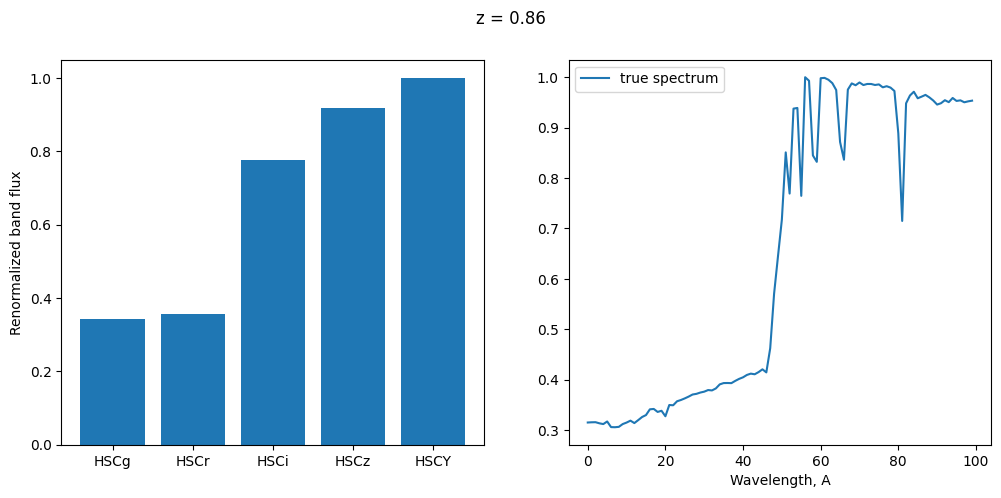

[ 0.85553279  0.01758463 -1.14017806]


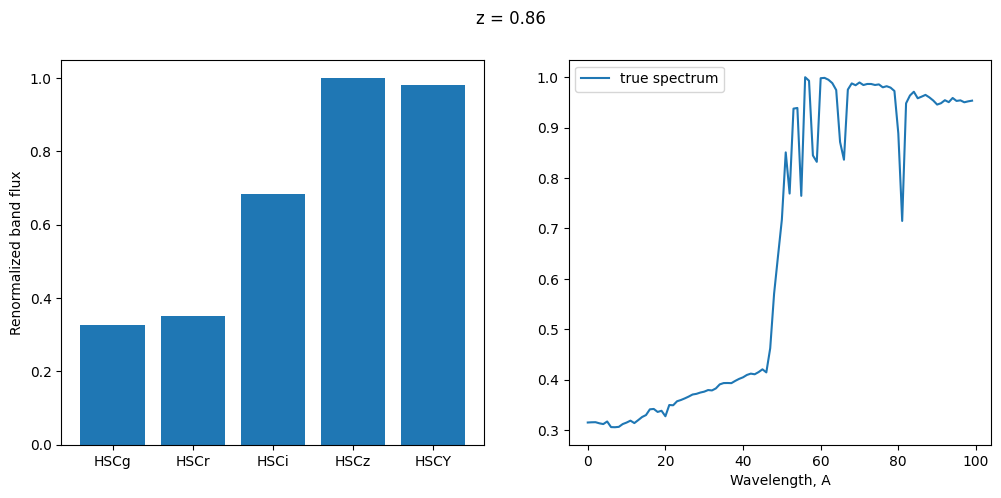

[ 0.85553279  0.01758463 -1.14017806]


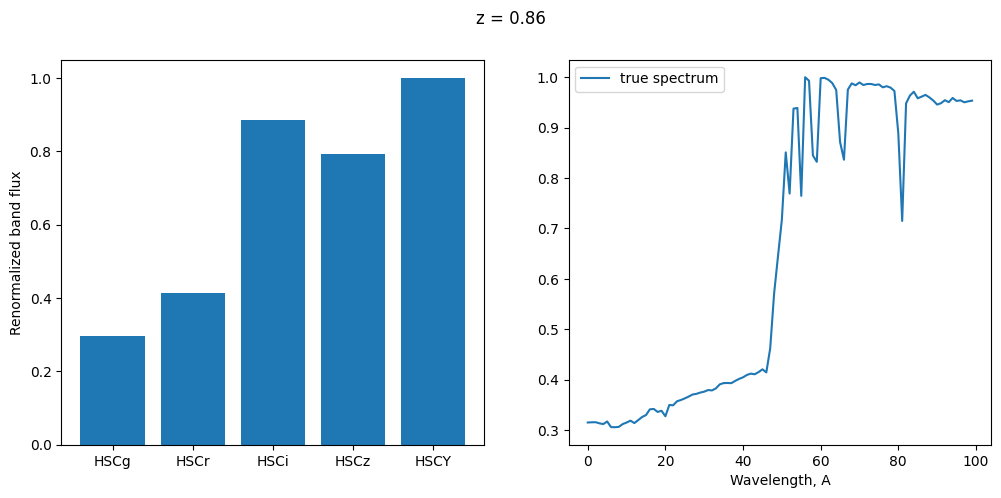

[ 0.85553279  0.01758463 -1.14017806]


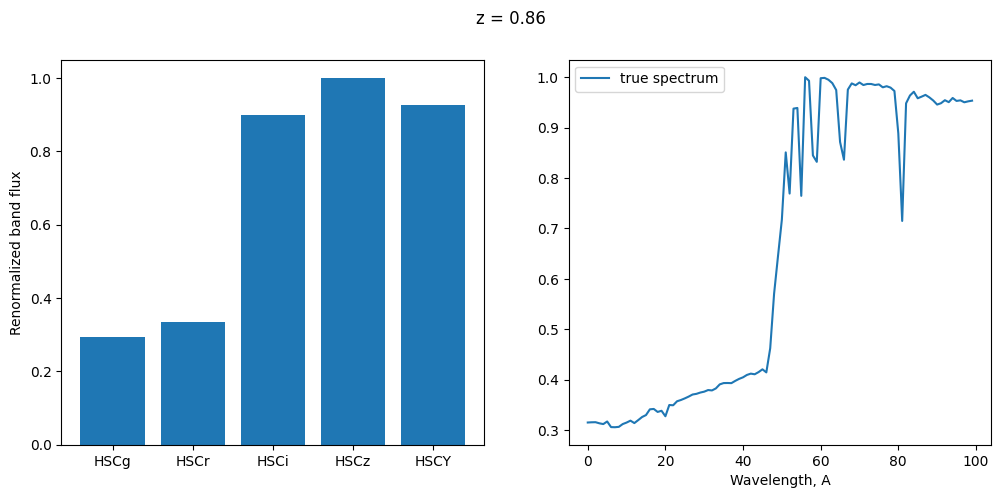

[ 0.85553279  0.01758463 -1.14017806]


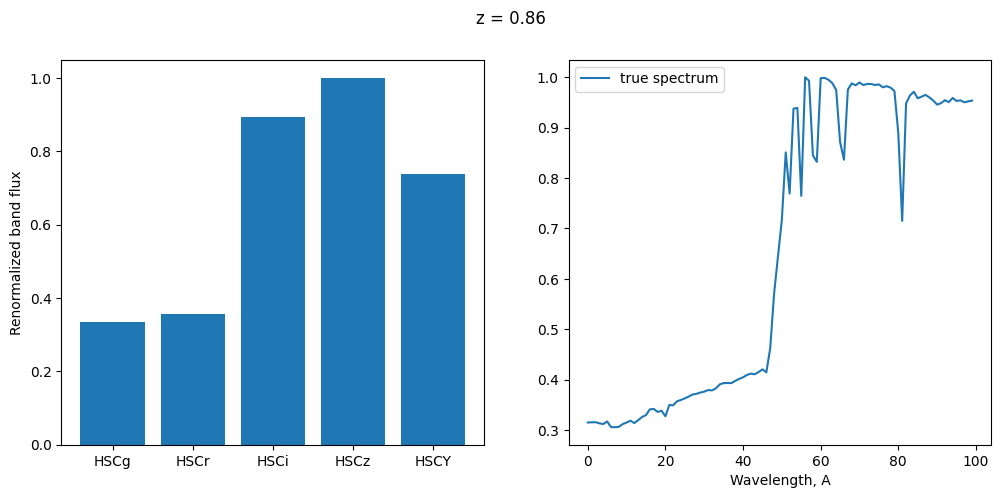

[ 0.85553279  0.01758463 -1.14017806]


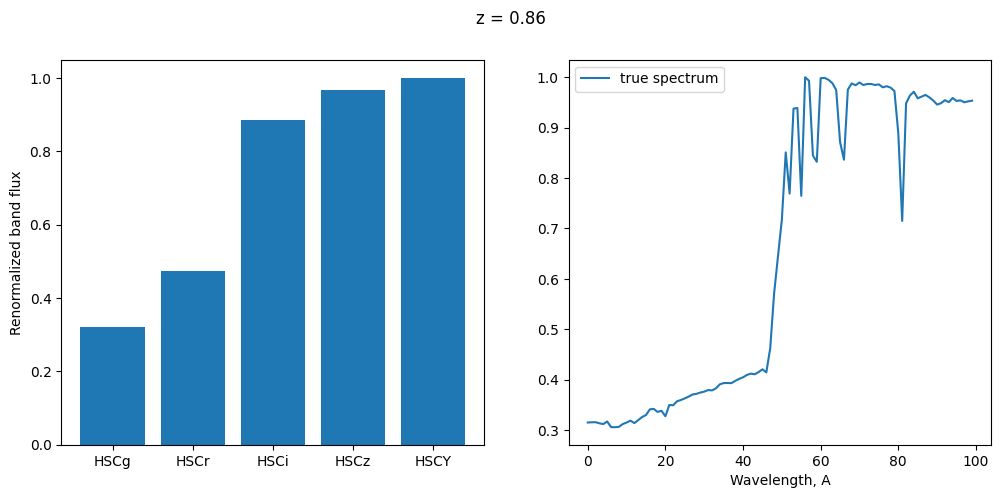

[ 0.85553279  0.01758463 -1.14017806]


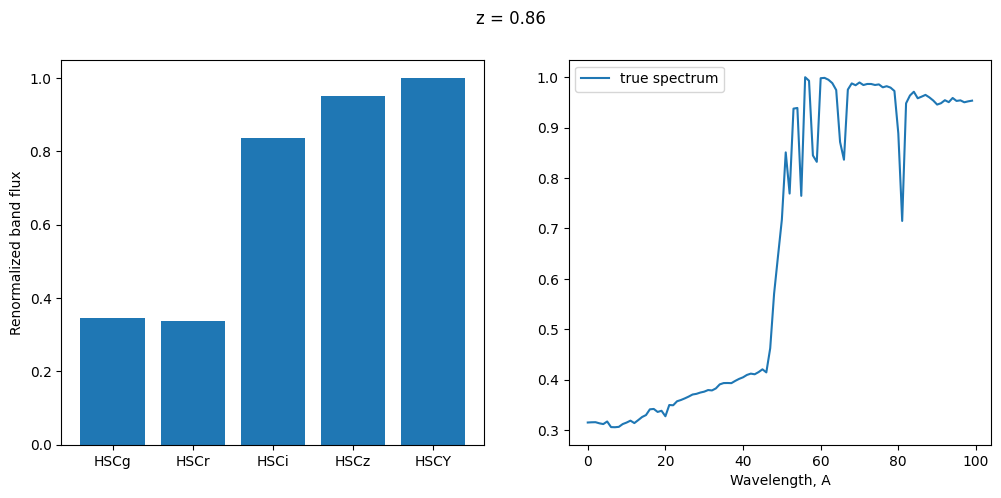

[ 0.85553279  0.01758463 -1.14017806]


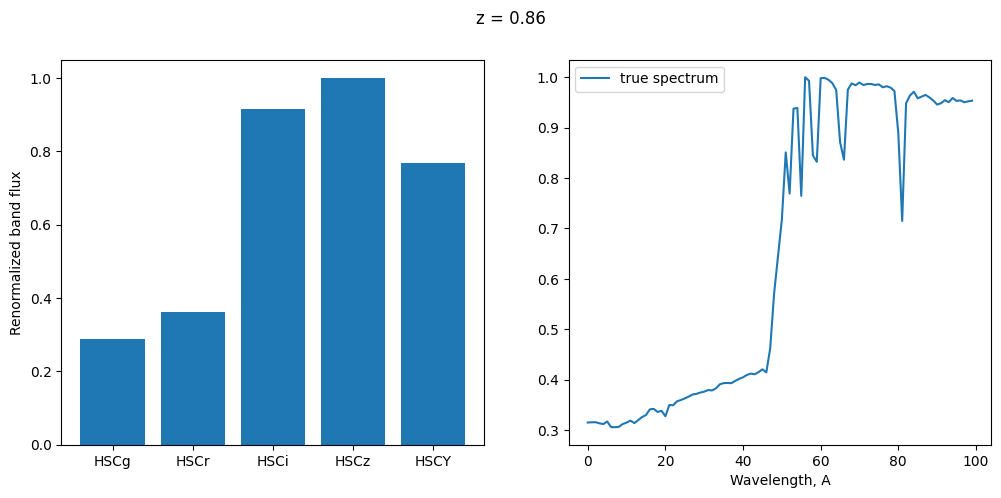

[ 0.85553279  0.01758463 -1.14017806]


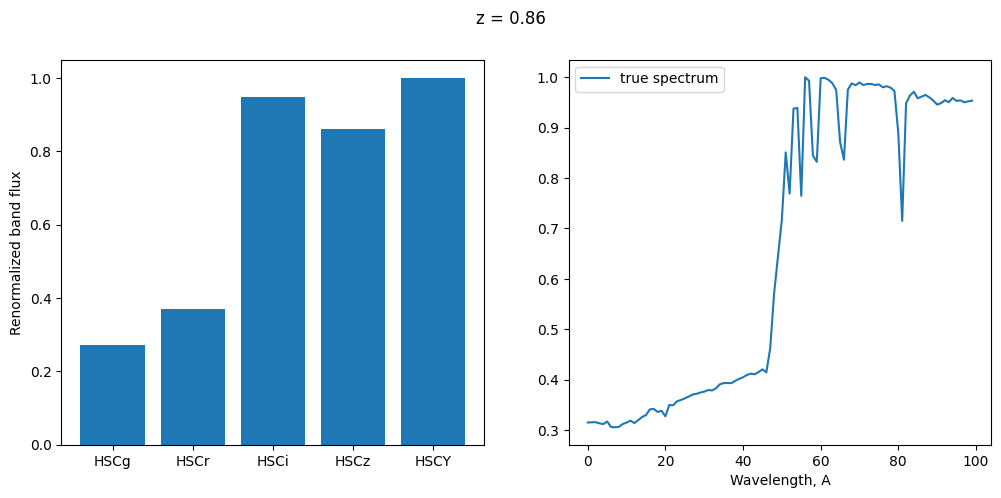

[ 0.85553279  0.01758463 -1.14017806]


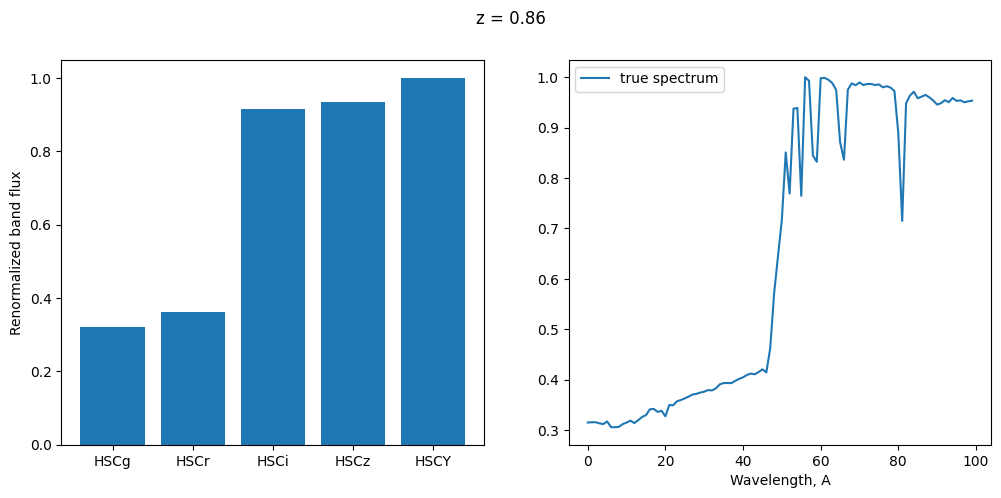

In [145]:
ii=1000
for ii in np.arange(ii, ii+10):
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(12, 5)
    axs[1].plot(spectra[ii], label="true spectrum")
    axs[1].set_xlabel('Wavelength, A')
    axs[0].bar(filer_names, integrals[ii])
    axs[0].set_ylabel('Renormalized band flux')
    print(params[ii])
    fig.suptitle('z = %.2f' % (params[ii, 0]))
    plt.legend()
    plt.show()

In [146]:
spvae = SpectraVAE(100, 16, beta=beta)
spvae.compile(optimizer=keras.optimizers.Adam())
hsp=spvae.fit(spectra, epochs=epochs, batch_size=128, validation_split=0.2)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_147']
Received: inputs=Tensor(shape=(128, 100))
  warnings.warn(msg)


500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - kl_loss: 4.2828 - loss: 0.2188 - reconstruction_loss: 0.1760 - val_kl_loss: 4.0351 - val_loss: 0.0918 - val_reconstruction_loss: 0.0515
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - kl_loss: 3.4762 - loss: 0.1010 - reconstruction_loss: 0.0662 - val_kl_loss: 3.6936 - val_loss: 0.0801 - val_reconstruction_loss: 0.0432
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - kl_loss: 3.2067 - loss: 0.0882 - reconstruction_loss: 0.0562 - val_kl_loss: 3.5471 - val_loss: 0.0733 - val_reconstruction_loss: 0.0378
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - kl_loss: 3.2620 - loss: 0.0800 - reconstruction_loss: 0.0474 - val_kl_loss: 3.2835 - val_loss: 0.0573 - val_reconstruction_loss: 0.0244
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - kl_loss: 3.1954 - loss: 0.0678 - reconstruction_loss: 0.0358 - val_kl_loss: 3.0354 - val_loss: 0.0544 - val_reconstruction_loss: 0.0240
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - kl_lo

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_147']
Received: inputs=Tensor(shape=(1, 100))
  warnings.warn(msg)


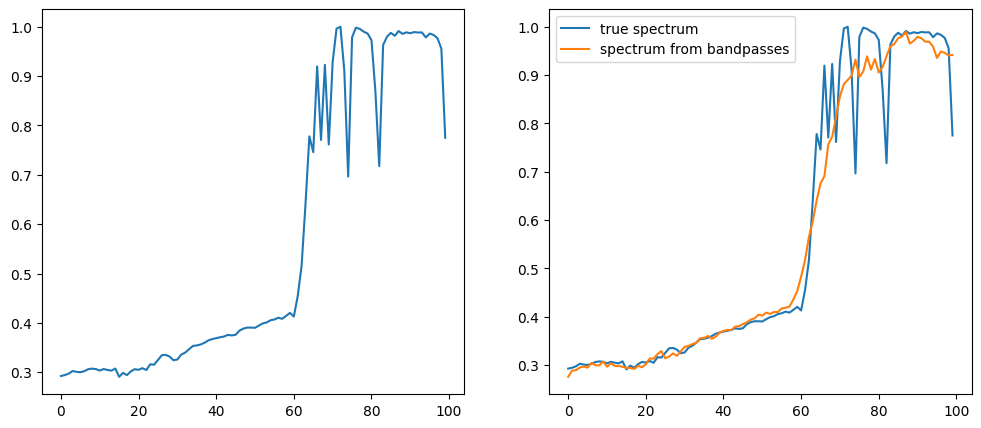

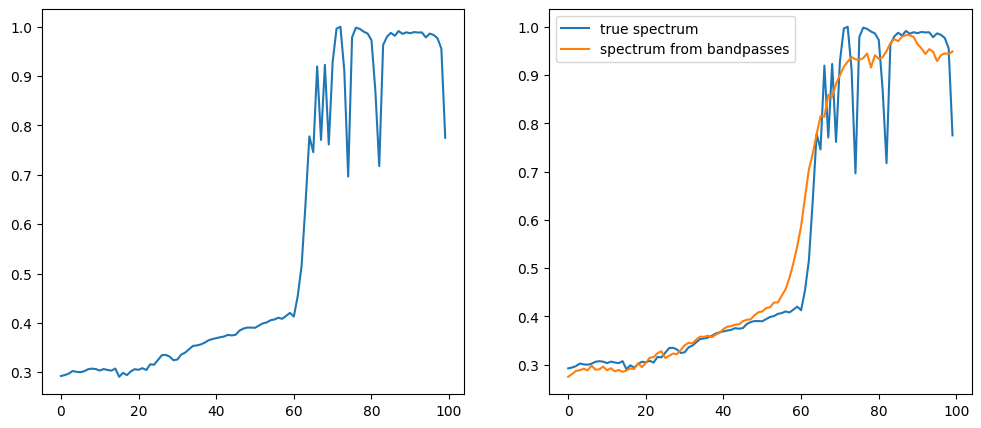

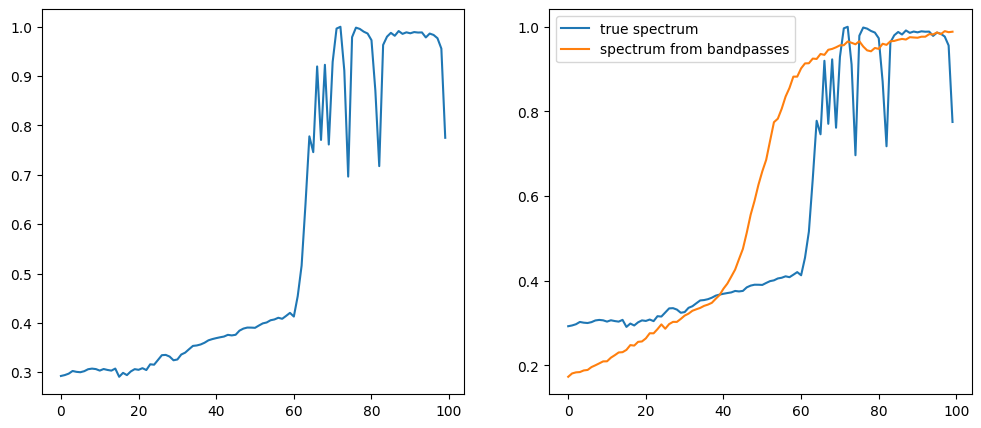

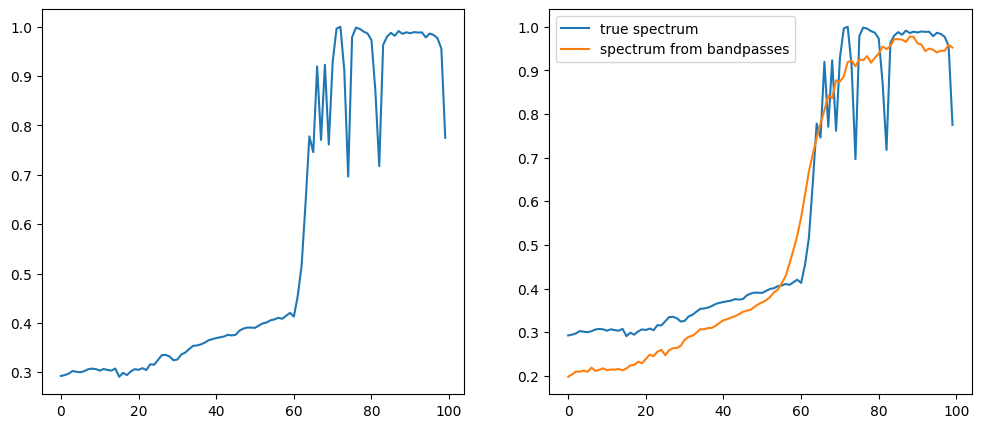

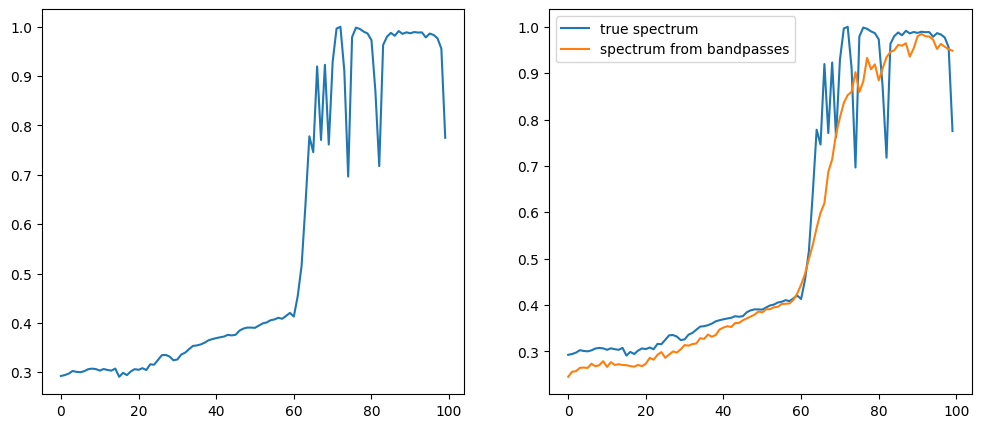

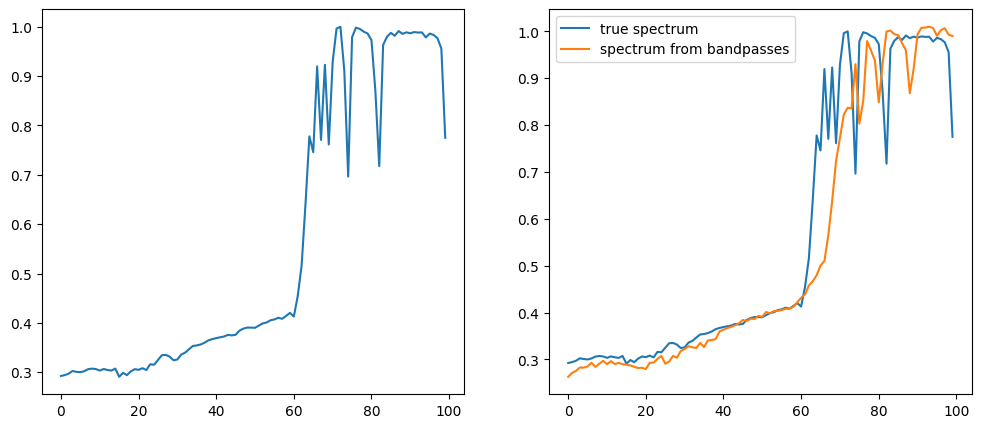

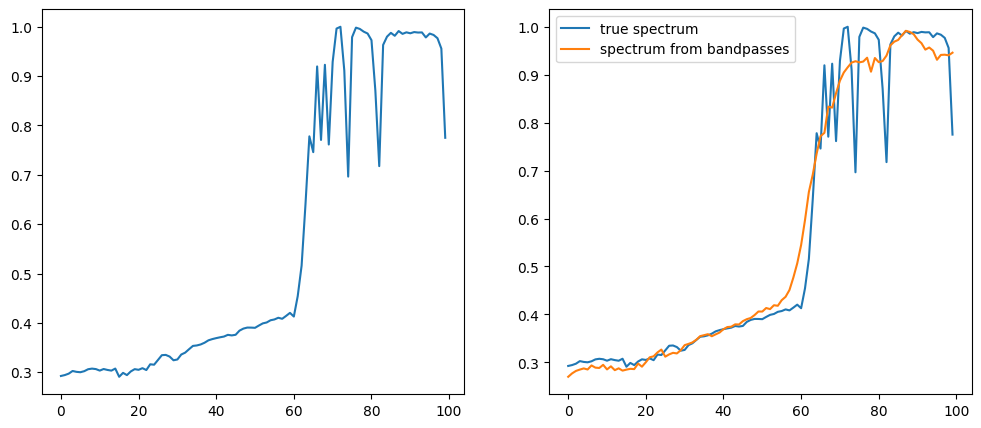

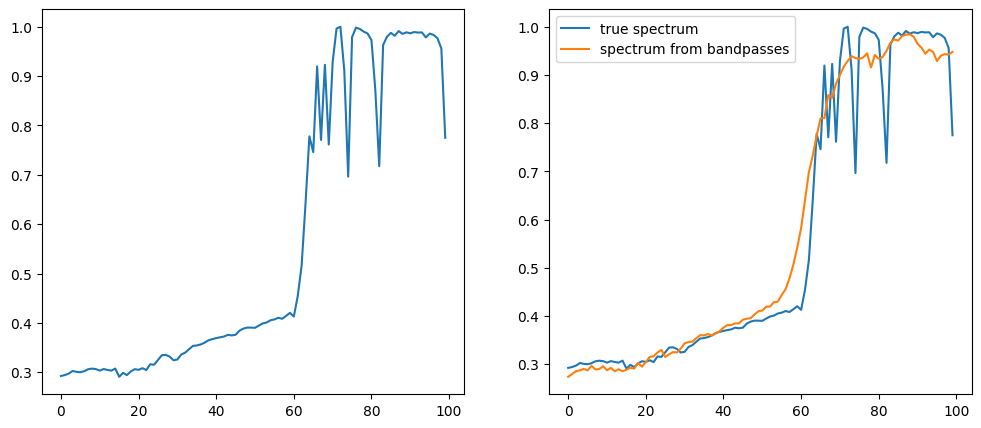

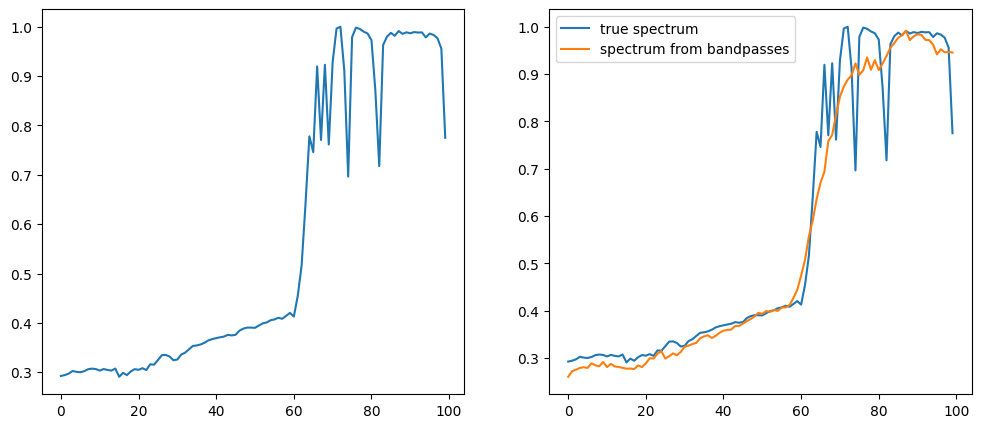

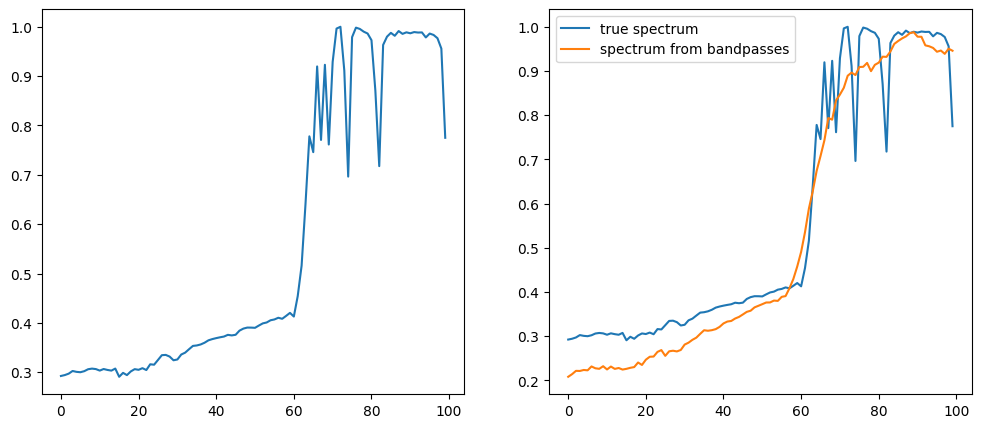

In [147]:
ii=1126
for ii in np.arange(ii, ii+10):
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(12, 5)
    axs[1].plot(spectra[ii], label="true spectrum")
    s = spvae(np.reshape(spectra[ii], (1,100)))
    s = np.reshape(s[0].numpy(),(100,))
    axs[1].plot(s, label="spectrum from bandpasses")
    axs[0].plot(range(len(spectra[ii])), spectra[ii])
    plt.legend()
    plt.show()

In [148]:
class BandPassVAE(keras.Model):
    def __init__(self, input_dim, latent_dim, beta=1, **kwargs):
        super().__init__(**kwargs)
        self.encoder_branch = build_dense_encoder_sed_branch((input_dim,))

        self.z_mean = layers.Dense(latent_dim, name='z_mean')(self.encoder_branch.output)
        self.z_log_var = layers.Dense(latent_dim, name='z_log_var')(self.encoder_branch.output)

        self.z = Sampling()([self.z_mean, self.z_log_var])

        self.encoder = keras.Model(self.encoder_branch.inputs, [self.z_mean, self.z_log_var, self.z], name='dense_encoder')

        self.decoder = spvae.decoder
        self.decoder.trainable = False  # Prevent training of the decoder

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.beta = beta
        #super().__init__(inputs=self.encoder.input, outputs=self.decoder.output, **kwargs)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def apply(self, data):
        data_in = data
        z_mean, z_log_var, z = self.encoder(data_in)
        reconstruction = self.decoder(z)
        return (z_mean, z_log_var, z, reconstruction)

    def call(self, data):
        (data_in, data_out) = data[0]
        return self.apply(data_in)[3]

    def train_step(self, data):
        (data_in, data_out) = data[0]
        with tf.GradientTape() as tape:
            (z_mean, z_log_var, z, reconstruction) = self.apply(data_in)
            reconstruction_loss = ops.mean(
                tf.keras.backend.mean(tf.keras.backend.square((data_out - reconstruction)/data_out))
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss*self.beta
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
       }

    def test_step(self, data):
        print(data)
        (data_in, data_out) = data[0]
        (z_mean, z_log_var, z, reconstruction) = self.apply(data_in)
        reconstruction_loss = ops.mean(
                #keras.losses.mean_squared_error(data, reconstruction),
                tf.keras.backend.mean(tf.keras.backend.square((data_out - reconstruction)/data_out))
        )
        kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
        kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss*self.beta
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def call(self, data):
        data_in  = data
        z_mean, z_log_var, z = self.encoder(data_in)
        reconstruction = self.decoder(z)
        return reconstruction

In [149]:
bpvae = BandPassVAE(5,16, beta=beta)
bpvae.compile(optimizer=keras.optimizers.Adam())
h=bpvae.fit((integrals, spectra), epochs=epochs, batch_size=128, validation_split=0.2)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_162']
Received: inputs=Tensor(shape=(128, 5))
  warnings.warn(msg)


492/500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 3.3070 - loss: 1.6722 - reconstruction_loss: 1.6391((<tf.Tensor 'data:0' shape=(128, 5) dtype=float32>, <tf.Tensor 'data_1:0' shape=(128, 100) dtype=float32>),)
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - kl_loss: 3.2880 - loss: 1.6454 - reconstruction_loss: 1.6126 - val_kl_loss: 2.1356 - val_loss: 0.1075 - val_reconstruction_loss: 0.0861
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - kl_loss: 2.1021 - loss: 0.1399 - reconstruction_loss: 0.1189 - val_kl_loss: 2.4608 - val_loss: 0.0780 - val_reconstruction_loss: 0.0534
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - kl_loss: 2.4160 - loss: 0.1122 - reconstruction_loss: 0.0880 - val_kl_loss: 3.0199 - val_loss: 0.0640 - val_reconstruction_loss: 0.0338
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - kl_loss: 2.5854 - loss: 0.1037 - reconstruction_loss: 0.0778 - val_kl_loss: 3.0440 - val_loss: 0.0653 - val_reconstruction_loss: 0.0349
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_162']
Received: inputs=Tensor(shape=(1, 5))
  warnings.warn(msg)


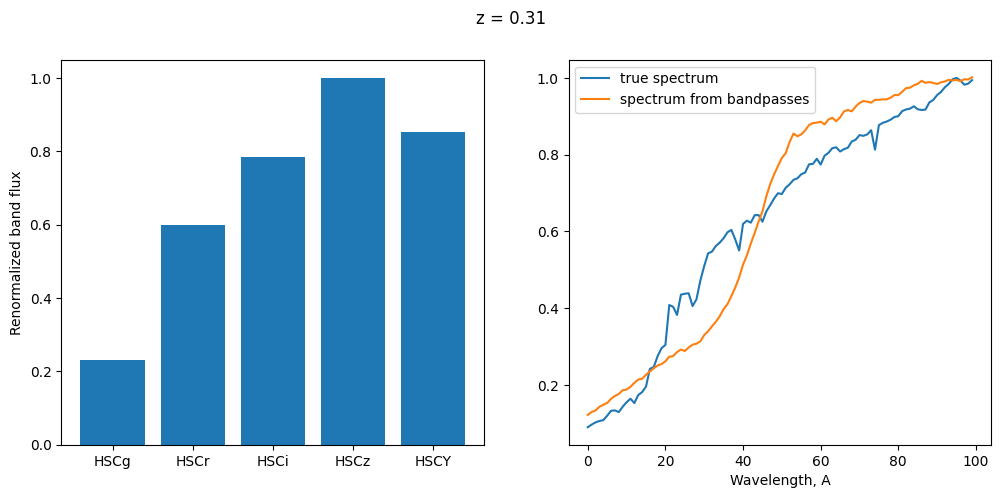

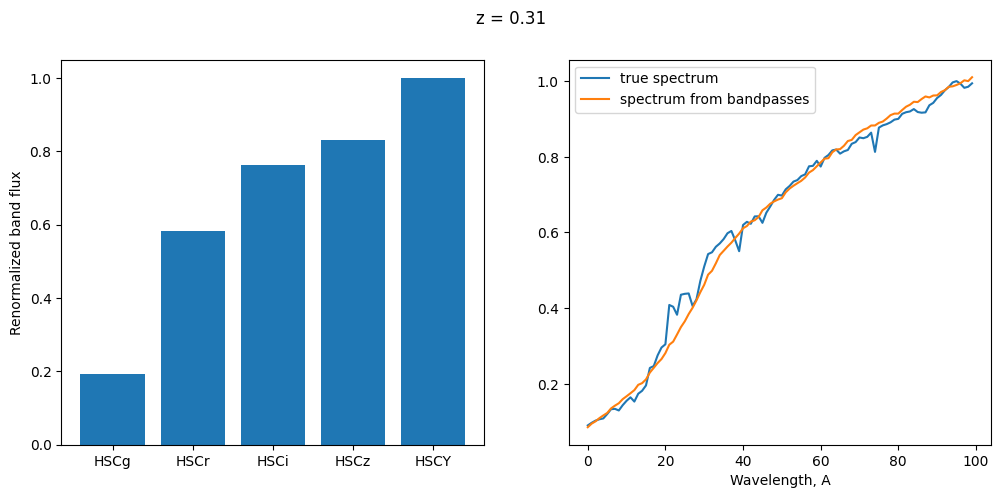

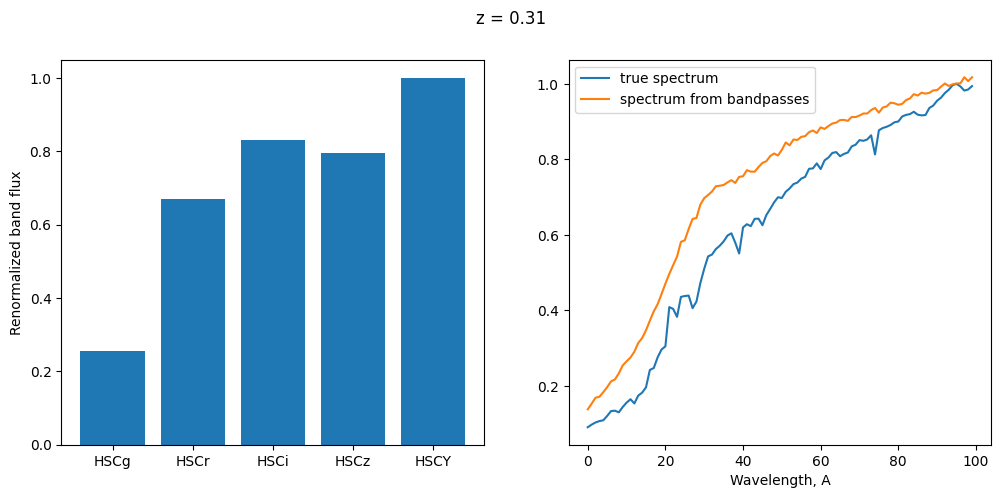

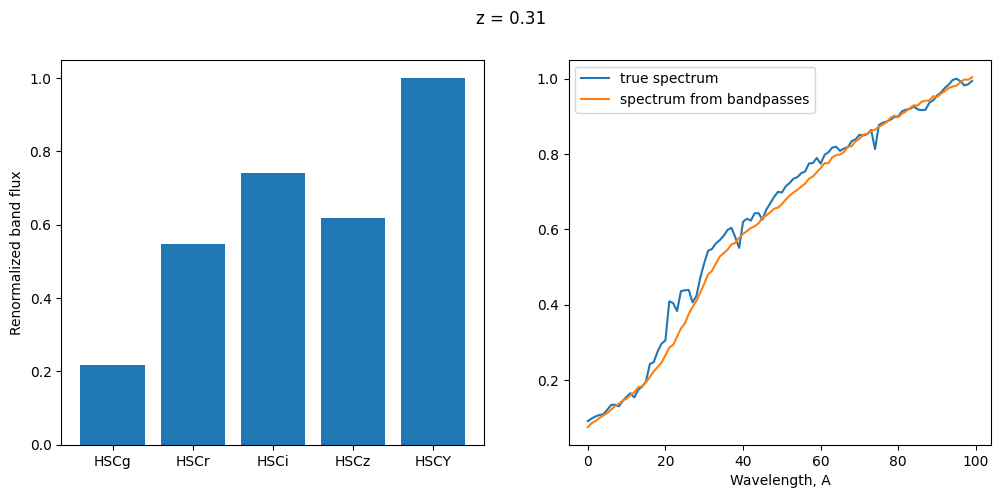

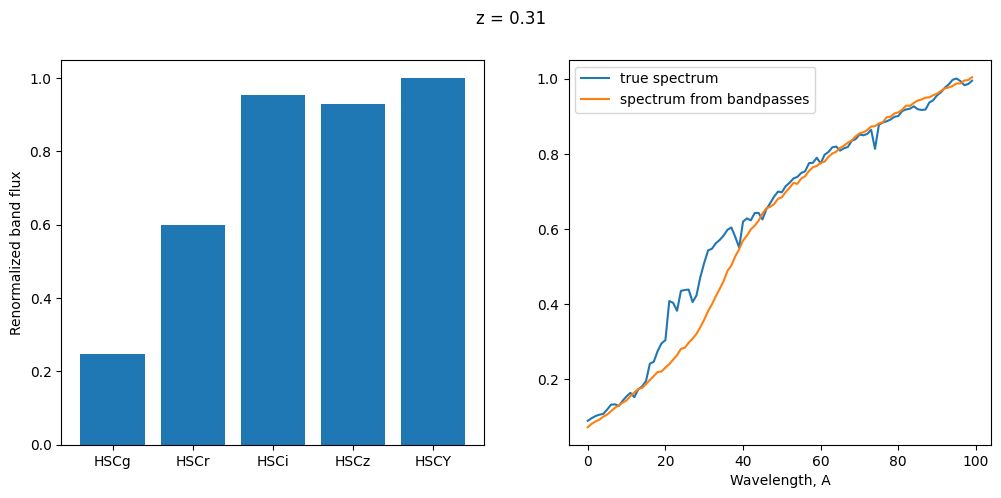

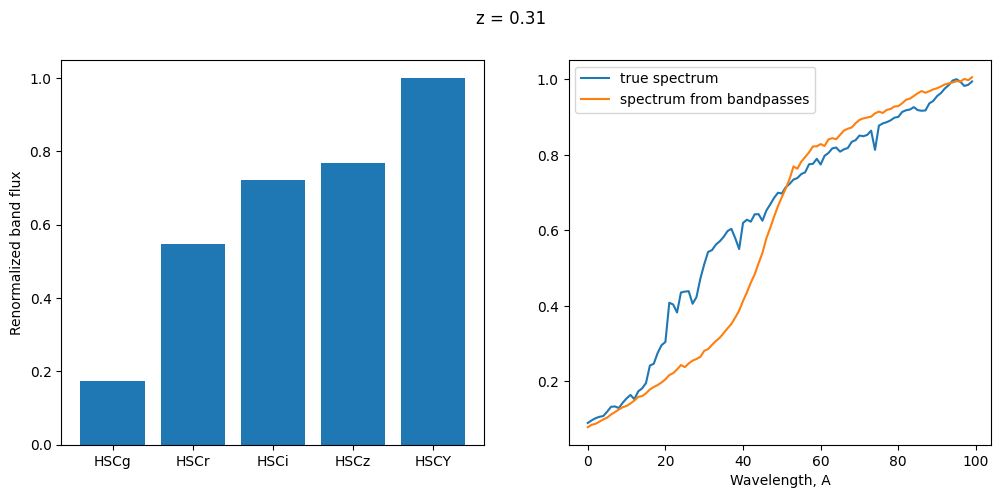

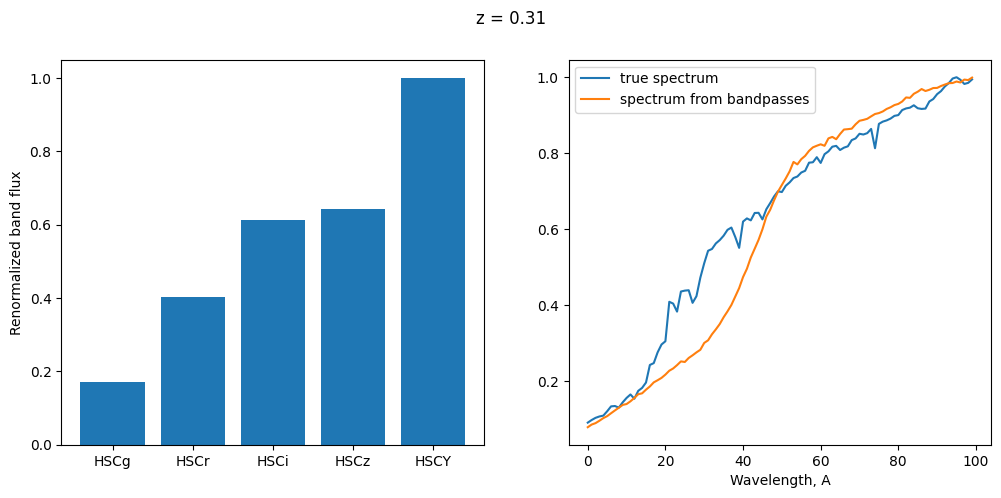

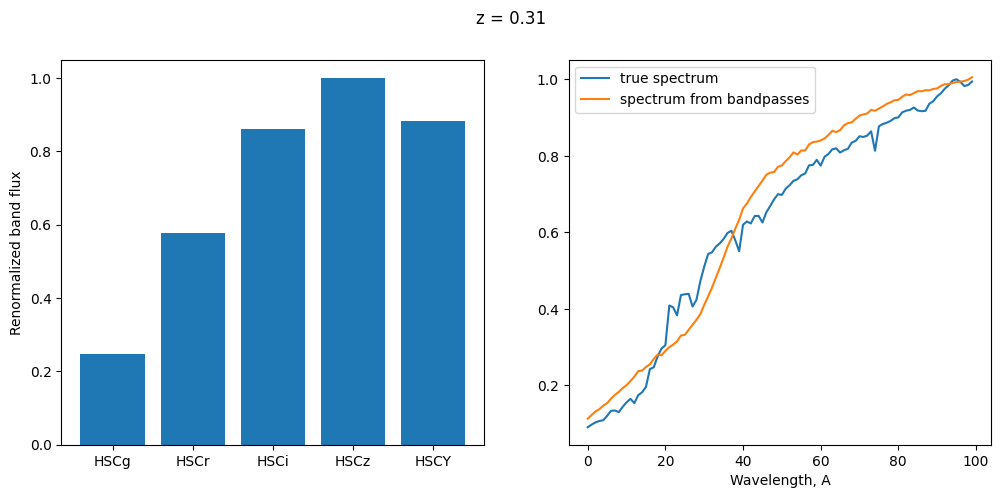

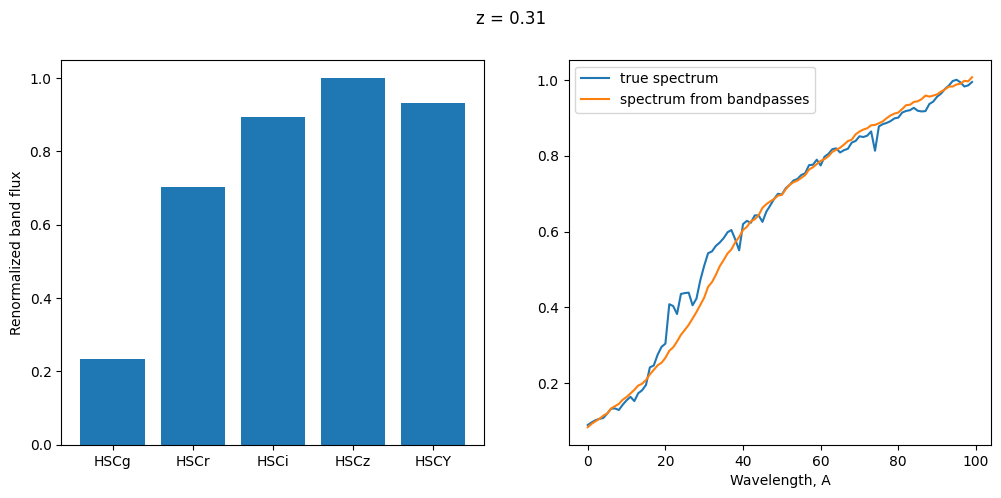

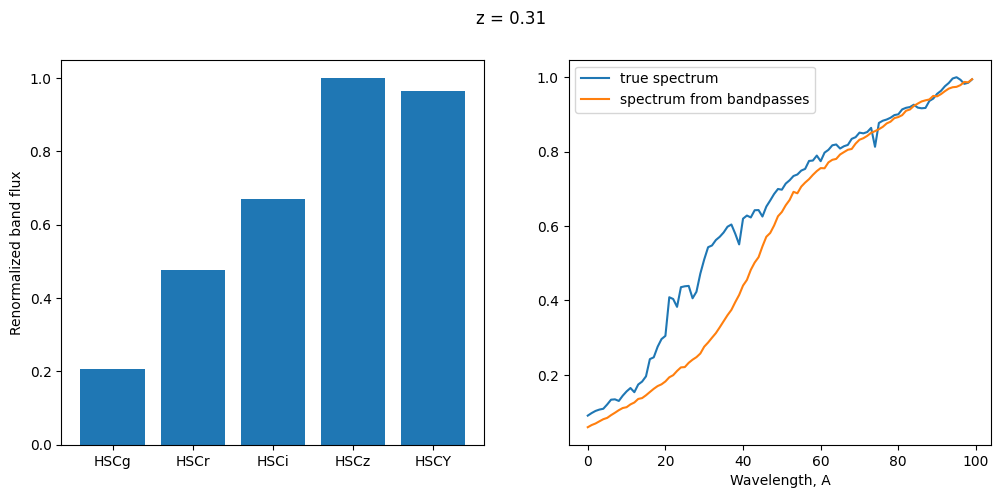

In [150]:
ii=10126
for ii in np.arange(ii, ii+10):
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(12, 5)
    axs[1].plot(spectra[ii], label="true spectrum")
    s = bpvae(np.reshape(integrals[ii], (1,5)))
    s = np.reshape(s[0].numpy(),(100,))
    axs[1].plot(s, label="spectrum from bandpasses")
    axs[1].set_xlabel('Wavelength, A')
    axs[0].bar(filer_names, integrals[ii])
    axs[0].set_ylabel('Renormalized band flux')
    fig.suptitle('z = %.2f' % (params[ii, 0]))
    plt.legend()
    plt.show()

In [151]:
def build_dense_decoder_param(latent_dim, output_dim):
    latent_inputs = layers.Input(shape=(latent_dim,), name='z_sampling')
    x = layers.Dense(16, activation='relu')(latent_inputs)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(output_dim[0])(x)

    decoder = keras.Model(latent_inputs, outputs, name='dense_decoder')
    return decoder


class ParamVAE(keras.Model):
    def __init__(self, input_dim, latent_dim, beta=1, **kwargs):
        super().__init__(**kwargs)
        self.encoder_branch = build_dense_encoder_sed_branch((input_dim,))

        self.z_mean = layers.Dense(latent_dim, name='z_mean')(self.encoder_branch.output)
        self.z_log_var = layers.Dense(latent_dim, name='z_log_var')(self.encoder_branch.output)

        self.z = Sampling()([self.z_mean, self.z_log_var])
        self.wei = np.array([10, 1, 1])
        self.wei = self.wei / np.sum(self.wei)
        self.encoder = bpvae.encoder
        self.encoder.trainable = False  # Prevent training of the decoder

        self.decoder = build_dense_decoder_param(latent_dim,(3,1))
        self.decoder.trainable = True  # Prevent training of the decoder

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.beta = beta
        #super().__init__(inputs=self.encoder.input, outputs=self.decoder.output, **kwargs)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def apply(self, data):
        data_in = data
        z_mean, z_log_var, z = self.encoder(data_in)
        reconstruction = self.decoder(z)
        return (z_mean, z_log_var, z, reconstruction)

    def call(self, data):
        (data_in, data_out) = data[0]
        return self.apply(data_in)[3]

    def train_step(self, data):
        (data_in, data_out) = data[0]
        with tf.GradientTape() as tape:
            (z_mean, z_log_var, z, reconstruction) = self.apply(data_in)
            reconstruction_loss = ops.mean(
                tf.keras.backend.square(data_out*self.wei - reconstruction*self.wei)
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss*self.beta
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
       }

    def test_step(self, data):
        print(data)
        (data_in, data_out) = data[0]
        (z_mean, z_log_var, z, reconstruction) = self.apply(data_in)
        reconstruction_loss = ops.mean(
                #keras.losses.mean_squared_error(data, reconstruction),
                tf.keras.backend.mean(tf.keras.backend.square(data_out - reconstruction))
        )
        kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
        kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss*self.beta
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def call(self, data):
        data_in  = data
        z_mean, z_log_var, z = self.encoder(data_in)
        reconstruction = self.decoder(z)
        return reconstruction

In [152]:
print(params[0])

parvae = ParamVAE(3,16, beta=beta)
parvae.compile(optimizer=keras.optimizers.Adam())
h=parvae.fit((integrals, params), epochs=epochs, batch_size=128, validation_split=0.2)

[ 1.08341411  0.02792815 -1.18475266]
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['dense_102/kernel', 'dense_102/bias', 'dense_103/kernel', 'dense_103/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 2.8559 - loss: 0.0465 - reconstruction_loss: 0.0179((<tf.Tensor 'data:0' shape=(128, 5) dtype=float32>, <tf.Tensor 'data_1:0' shape=(128, 3) dtype=float32>),)
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - kl_loss: 2.8559 - loss: 0.0465 - reconstruction_loss: 0.0179 - val_kl_loss: 2.8567 - val_loss: 0.1118 - val_reconstruction_loss: 0.0832
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_loss: 2.8560 - loss: 0.0371 - reconstruction_loss: 0.0085 - val_kl_loss: 2.8567 - val_loss: 0.1078 - val_reconstruction_loss: 0.0792
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 2.8560 - loss: 0.0366 - reconstruction_loss: 0.0081 - val_kl_loss: 2.8567 - val_loss: 0.1039 - val_reconstruction_loss: 0.0754
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - kl_loss: 2.8561 - loss: 0.0365 - reconstruction_loss: 0.0079 - val_kl_loss: 2.8567 - val_loss: 0.1108 - val_reconstruction_loss: 0.0822
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_162']
Received: inputs=Tensor(shape=(80000, 5))
  warnings.warn(msg)


tf.Tensor([ 1.0280588   0.03321837 -0.7561692 ], shape=(3,), dtype=float32) [ 1.08341411  0.02792815 -1.18475266]


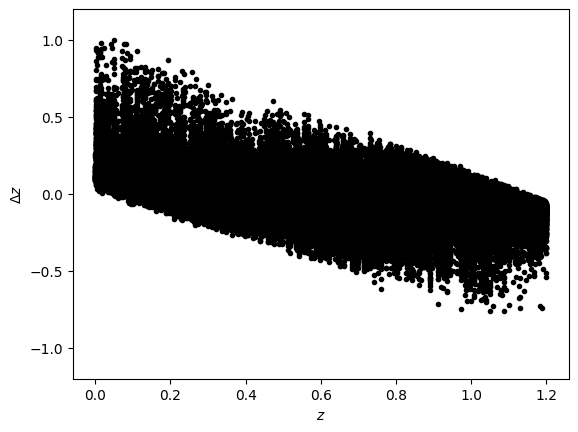

In [153]:
pnames = ['z', 't', '[Z/H]']

s = parvae(np.reshape(integrals[:80000], (80000,5)))
p = params[:80000]

res = s - p

print(s[0], p[0])
axs = (0, 0)


plx = p[:, axs[0]]
ply = res[:, axs[1]]
plt.plot(plx, ply, 'k.')
plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
plt.show()


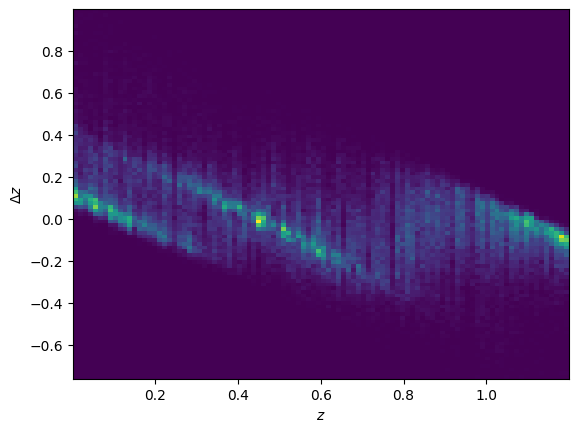

In [154]:
plx = p[:, axs[0]]
ply = res[:, axs[1]]
plt.hist2d(plx, ply, bins=100)
#plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
plt.show()

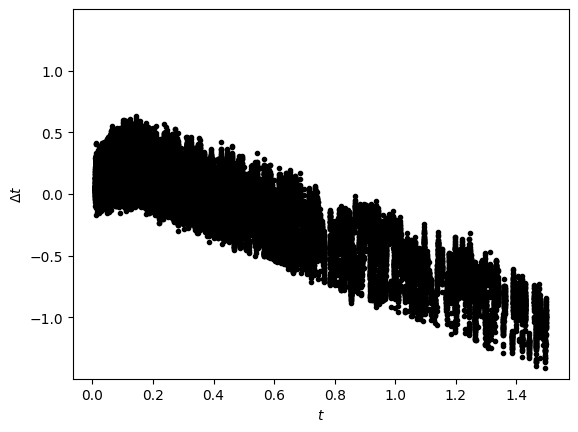

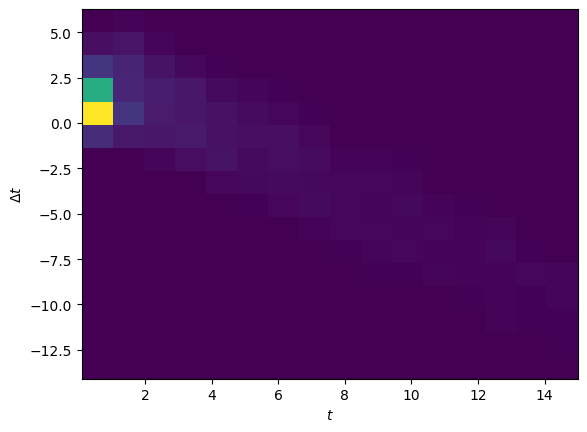

In [155]:
axs = (1, 1)


plx = p[:, axs[0]]
ply = res[:, axs[1]]
plt.plot(plx, ply, 'k.')
plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
plt.show()

plx = p[:, axs[0]] * 10
ply = res[:, axs[1]] * 10.0
plt.hist2d(plx, ply, bins=16)
#plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
plt.show()

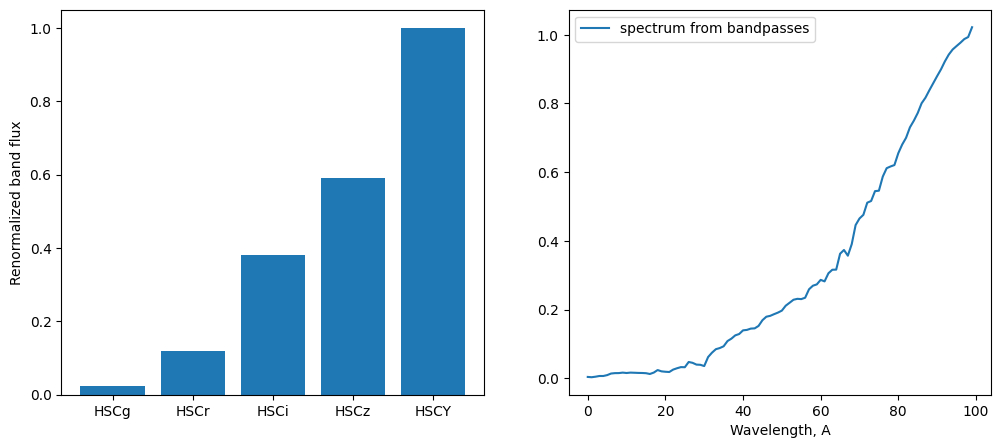

tf.Tensor([[ 0.91186047  0.6962411  -0.27240744]], shape=(1, 3), dtype=float32)


In [156]:
mags = np.array([24.369846, 22.666399, 21.405907, 20.927715, 20.358585])

bandfl = 10**(-0.4*mags)

bandfl /= np.max(bandfl)


fig, axs = plt.subplots(1, 2)
fig.set_size_inches(12, 5)
#axs[1].plot(wllr, spectra[ii], label="true spectrum")
s = bpvae(np.reshape(bandfl, (1,5)))
s = np.reshape(s[0].numpy(),(100,))
axs[1].plot(s, label="spectrum from bandpasses")
axs[1].set_xlabel('Wavelength, A')
axs[0].bar(filer_names, bandfl)
axs[0].set_ylabel('Renormalized band flux')
#fig.suptitle('z = %.2f' % (params[ii, 0]))
plt.legend()
plt.show()

s = parvae(np.reshape(bandfl, (1,5)))
print(s)

In [157]:
from astropy.table import Table

t_hsc_ = Table.read('http://gal-03.voxastro.org/~kirg/tmp/DESI_DR1_HSCSSP_clean_RCSED.fits')

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_162']
Received: inputs=Tensor(shape=(111040, 5))
  warnings.warn(msg)


tf.Tensor([ 0.48887354  0.303028   -0.7261287 ], shape=(3,), dtype=float32) 0.1017429429254491


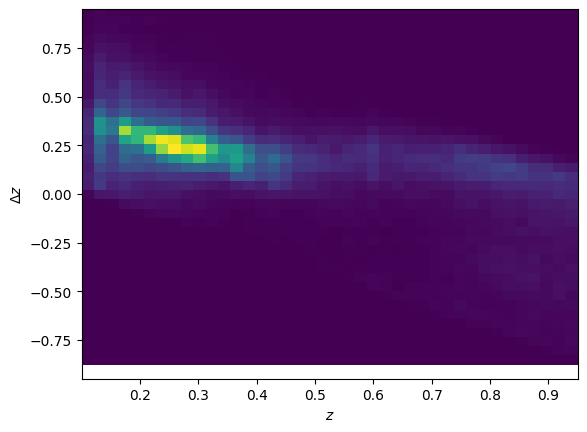

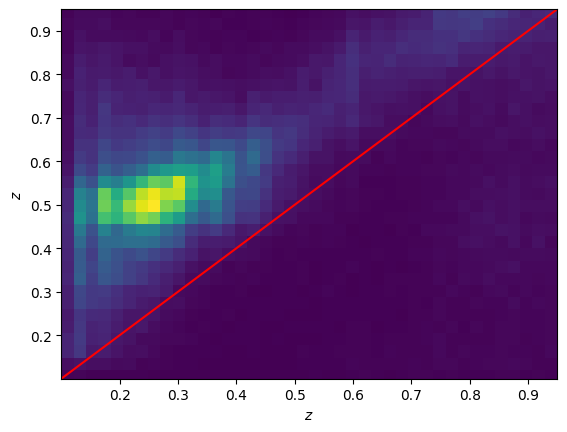

In [158]:
hsc_int = []
hsz_z = []
t_hsc = t_hsc_[((t_hsc_['z'] > 0.1) & (t_hsc_['z'] < 0.95) & (t_hsc_['zwarn'] == 0))]

for r in t_hsc:
    mags = mags = np.array([r['g_kronflux_mag'], r['r_kronflux_mag'], r['i_kronflux_mag'], r['z_kronflux_mag'], r['y_kronflux_mag']])
    bandfl = 10**(-0.4*mags)
    bandfl /= np.max(bandfl)
    hsc_int.append(bandfl)
    hsz_z.append(r['z'])

n = len(hsc_int)
pnames = ['z', 't', '[Z/H]']

s = parvae(np.reshape(hsc_int[:n], (n,5)))
p = hsz_z[:n]

res = s[:, 0] - p

print(s[0], p[0])
axs = (0, 0)


plx = p[:]
ply = res[:]
plt.hist2d(plx, ply, bins=40)
plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
plt.show()


plx = p[:]
ply = res[:]
plt.hist2d(p[:], s[:, 0], bins=40)
plt.plot([0, 1], [0, 1], color='red')
plt.ylim(np.min(p[:]), np.max(p[:]))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$ ' + pnames[axs[1]] + '$')
plt.show()

t_hsc['z_photo'] = s[:, 0]


tf.Tensor([ 0.47230598  0.30928767 -0.7254226 ], shape=(3,), dtype=float32) 0.1017429429254491


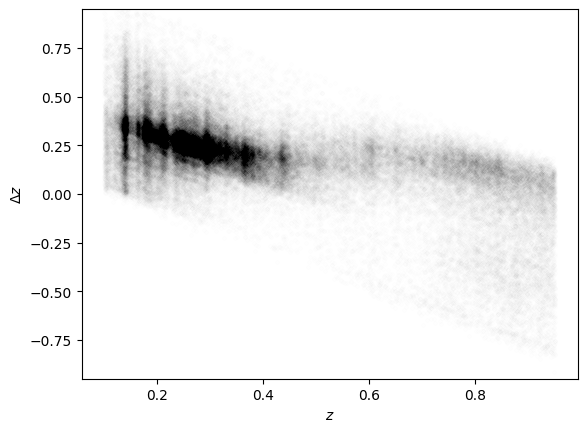

In [159]:
hsc_int = []
hsz_z = []
t_hsc = t_hsc_[((t_hsc_['z'] > 0.1) & (t_hsc_['z'] < 0.95) & (t_hsc_['zwarn'] == 0))]

for r in t_hsc:
    mags = mags = np.array([r['g_kronflux_mag'], r['r_kronflux_mag'], r['i_kronflux_mag'], r['z_kronflux_mag'], r['y_kronflux_mag']])
    bandfl = 10**(-0.4*mags)
    bandfl /= np.max(bandfl)
    hsc_int.append(bandfl)
    hsz_z.append(r['z'])

n = len(hsc_int)
pnames = ['z', 't', '[Z/H]']

s = parvae(np.reshape(hsc_int[:n], (n,5)))
p = hsz_z[:n]

res = s[:, 0] - p
print(s[0], p[0])
axs = (0, 0)


plx = p[:]
ply = res[:]
plt.plot(plx, ply, marker='.', color='black', linestyle='None', alpha=0.005)
plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
plt.show()
t_hsc['z_photo'] = s[:, 0]

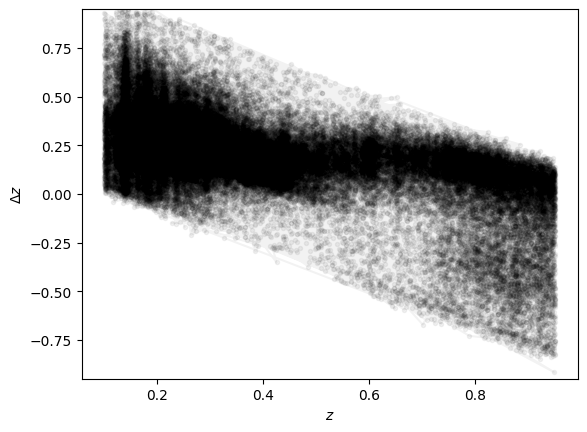

In [160]:
plx = p[:]
ply = res[:]
plt.plot(plx, ply, marker='.', color='black', linestyle=None, alpha=0.05)
plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
plt.show()


In [161]:
t_hsc[((t_hsc['z'] < 0.5) & (t_hsc['z'] > 0.25) & (t_hsc['z_photo'] <0.15) & (t_hsc['objid'] > 0))]

object_id,ra,dec,g_kronflux_mag,r_kronflux_mag,i_kronflux_mag,z_kronflux_mag,y_kronflux_mag,z,mean_fiber_ra,targetid,tileid,zwarn,objid,specobjid,mjd,plate,fiberid,ra_2,dec_2,z_2,zerr,zconf,petror50_r,e_bv,specclass,corrmag_fuv,corrmag_nuv,corrmag_u,corrmag_g,corrmag_r,corrmag_i,corrmag_z,corrmag_y,corrmag_j,corrmag_h,corrmag_k,corrmag_fuv_err,corrmag_nuv_err,corrmag_u_err,corrmag_g_err,corrmag_r_err,corrmag_i_err,corrmag_z_err,corrmag_y_err,corrmag_j_err,corrmag_h_err,corrmag_k_err,kcorr_fuv,kcorr_nuv,kcorr_u,kcorr_g,kcorr_r,kcorr_i,kcorr_z,kcorr_y,kcorr_j,kcorr_h,kcorr_k,ssp_radvel,ssp_radvel_err,ssp_veldisp,ssp_veldisp_err,ssp_age,ssp_age_err,ssp_met,ssp_met_err,ssp_chi2,exp_radvel,exp_radvel_err,exp_veldisp,exp_veldisp_err,exp_tau,exp_tau_err,exp_met,exp_met_err,exp_chi2,zy_offset,spectrum_snr,Separation,z_photo
,,,,,,,,,deg,,,,,,d,,,deg,deg,,,,arcsec,mag,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,km / s,km / s,km / s,km / s,Myr,Myr,,,,km / s,km / s,km / s,km / s,Myr,Myr,,,,mag,,arcsec,
int64,float64,float64,float32,float32,float32,float32,float32,float64,float64,int64,int32,int64,int64,int64,int32,int16,int16,float64,float64,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float32


In [162]:
def corner_plot(r, max_params):
    axs = tuple(range(min(max_params, r[0].shape[1])))  # Ensure indices do not exceed max dimensions
    fig, axes = plt.subplots(len(axs), len(axs), figsize=(10, 10))

    for i, ax_i in enumerate(axs):
        for j, ax_j in enumerate(axs):
            ax = axes[i, j]

            if i == j:
                # Diagonal: 1D histogram
                ax.hist(r[0][:, ax_i], bins=100, color='steelblue', alpha=0.7)
            elif i > j:
                # Lower triangle: 2D histogram
                ax.hist2d(r[0][:, ax_j], r[0][:, ax_i], bins=100, cmap='Blues')
            else:
                # Upper triangle: empty space
                ax.set_visible(False)

            # Remove ticks for clarity
            ax.set_xticks([])
            ax.set_yticks([])

    plt.tight_layout()


    object_id             ra                 dec         g_kronflux_mag r_kronflux_mag i_kronflux_mag z_kronflux_mag y_kronflux_mag         z            mean_fiber_ra        targetid     tileid zwarn       objid            specobjid       mjd  plate fiberid     ra_2      dec_2      z_2        zerr     zconf  petror50_r     e_bv    specclass corrmag_fuv corrmag_nuv corrmag_u corrmag_g corrmag_r corrmag_i corrmag_z corrmag_y corrmag_j corrmag_h corrmag_k corrmag_fuv_err corrmag_nuv_err corrmag_u_err corrmag_g_err corrmag_r_err corrmag_i_err corrmag_z_err corrmag_y_err corrmag_j_err corrmag_h_err corrmag_k_err  kcorr_fuv    kcorr_nuv   kcorr_u    kcorr_g    kcorr_r      kcorr_i     kcorr_z     kcorr_y     kcorr_j     kcorr_h    kcorr_k   ssp_radvel ssp_radvel_err ssp_veldisp ssp_veldisp_err  ssp_age  ssp_age_err  ssp_met   ssp_met_err  ssp_chi2 exp_radvel exp_radvel_err exp_veldisp exp_veldisp_err  exp_tau  exp_tau_err   exp_met   exp_met_err  exp_chi2   zy_offset  spectrum_snr      Separ

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_162']
Received: inputs=Tensor(shape=(1, 5))
  warnings.warn(msg)


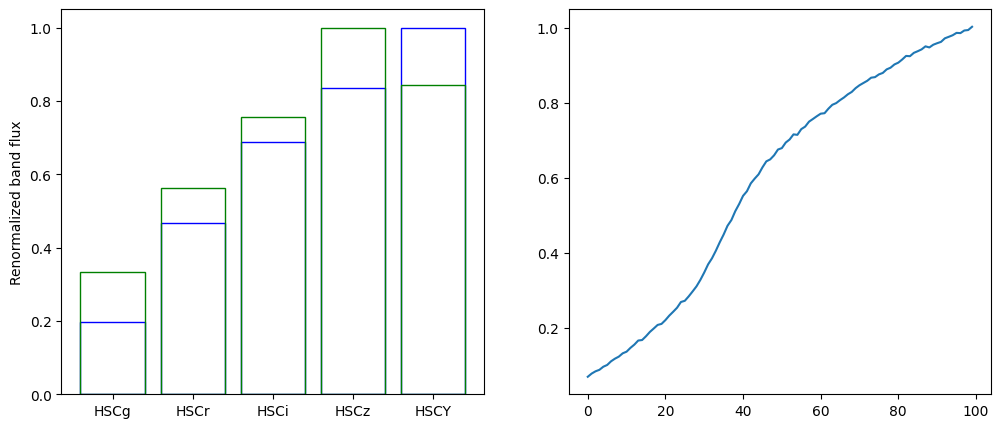

(<tf.Tensor: shape=(1, 16), dtype=float32, numpy=
array([[ 0.13674435, -0.01284186,  0.01338181,  0.00527511,  0.00490348,
         0.01277759, -0.00800836,  0.01259281,  0.01648714, -0.00829743,
         0.00472292, -0.00364414, -0.01058333, -0.02718791,  0.02848355,
         0.00963416]], dtype=float32)>, <tf.Tensor: shape=(1, 16), dtype=float32, numpy=
array([[-1.6349702e+00, -5.4035457e-03,  1.3683230e-02,  9.8626791e-03,
        -1.9493687e-03, -1.8194608e-02, -4.9999245e-03, -4.6447255e-03,
        -9.3006715e-03, -1.7551109e-02, -2.3838744e-02, -6.3096322e-03,
         6.0122684e-03,  4.9969763e-04, -4.3566470e+00, -4.9246773e-03]],
      dtype=float32)>, <tf.Tensor: shape=(1, 16), dtype=float32, numpy=
array([[ 0.40026048, -0.00831589,  0.8978374 ,  0.07115915, -0.24152187,
        -1.5001571 ,  0.782532  , -0.46764928, -1.4777334 , -2.2514741 ,
        -1.6600456 ,  0.54804474,  0.59508914,  0.46064648, -0.02248589,
        -1.3639262 ]], dtype=float32)>, <tf.Tensor: shape=(1,

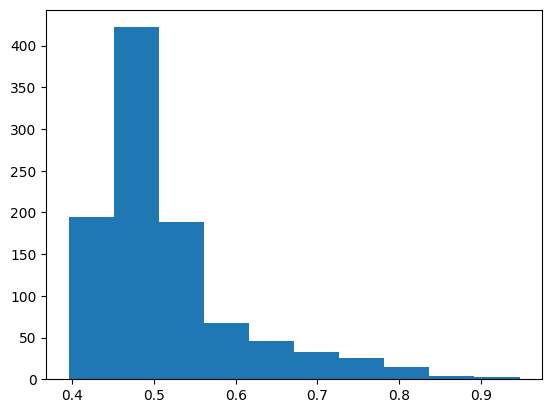

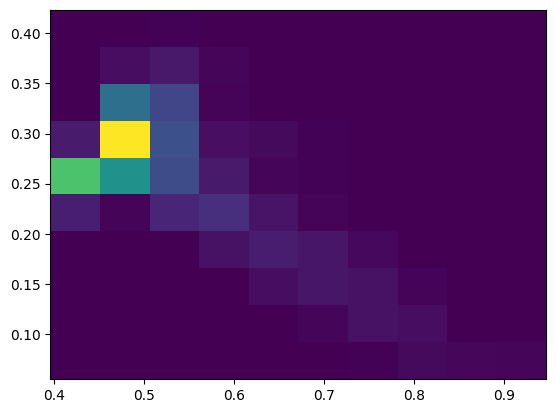

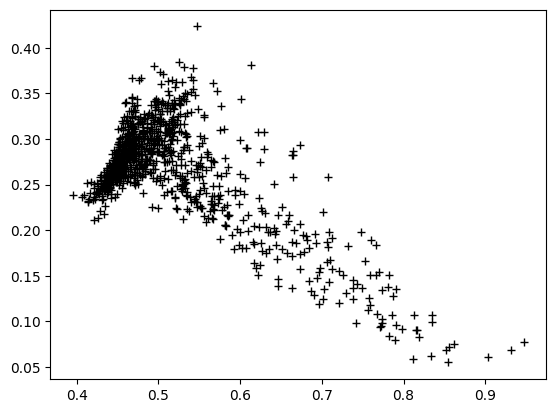

In [163]:
r = t_hsc[t_hsc['targetid'] == 39627761148494904][0]

ii = 50500

print(r)

mags = np.array([r['g_kronflux_mag'], r['r_kronflux_mag'], r['i_kronflux_mag'], r['z_kronflux_mag'], r['y_kronflux_mag']])
bandfl = 10**(-0.4*mags)

bandfl /= np.max(bandfl)

print(params[ii])

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(12, 5)
#axs[1].plot(wllr, spectra[ii], label="true spectrum")
#s = bpvae(np.reshape(bandfl, (1,5)))
#s = np.reshape(s[0].numpy(),(100,))
#axs[1].plot(wllr, s, label="spectrum from bandpasses")
#axs[1].set_xlabel('Wavelength, A')
axs[0].bar(filer_names, bandfl, fill=False, edgecolor='blue')
axs[0].bar(filer_names, integrals[ii], fill=False, edgecolor='green')
axs[0].set_ylabel('Renormalized band flux')
#fig.suptitle('z = %.2f' % (params[ii, 0]))

s = bpvae(np.reshape(bandfl, (1,5)))
s = np.reshape(s[0].numpy(),(100,))
axs[1].plot(s)

#plt.legend()
plt.show()

p_ls = parvae.apply(np.reshape(bandfl, (1,5)))


p = parvae(np.reshape(bandfl, (1,5)))

print(p_ls)

param_evals = []

nsmpl = 1000
for i in range(nsmpl):
    p_ls = parvae(np.reshape(bandfl, (1,5)))
    param_evals.append(p_ls[0].numpy())

param_evals = np.array(param_evals)
plt.hist(param_evals[:, 0])
plt.show()


plt.hist2d(param_evals[:, 0], param_evals[:, 1])
plt.show()

plt.plot(param_evals[:, 0], param_evals[:, 1], 'k+')
plt.show()

    object_id             ra                 dec         g_kronflux_mag r_kronflux_mag i_kronflux_mag z_kronflux_mag y_kronflux_mag         z            mean_fiber_ra        targetid     tileid zwarn       objid            specobjid       mjd  plate fiberid     ra_2      dec_2      z_2        zerr     zconf  petror50_r     e_bv    specclass corrmag_fuv corrmag_nuv corrmag_u corrmag_g corrmag_r corrmag_i corrmag_z corrmag_y corrmag_j corrmag_h corrmag_k corrmag_fuv_err corrmag_nuv_err corrmag_u_err corrmag_g_err corrmag_r_err corrmag_i_err corrmag_z_err corrmag_y_err corrmag_j_err corrmag_h_err corrmag_k_err  kcorr_fuv    kcorr_nuv   kcorr_u    kcorr_g    kcorr_r      kcorr_i     kcorr_z     kcorr_y     kcorr_j     kcorr_h    kcorr_k   ssp_radvel ssp_radvel_err ssp_veldisp ssp_veldisp_err  ssp_age  ssp_age_err  ssp_met   ssp_met_err  ssp_chi2 exp_radvel exp_radvel_err exp_veldisp exp_veldisp_err  exp_tau  exp_tau_err   exp_met   exp_met_err  exp_chi2   zy_offset  spectrum_snr      Separ

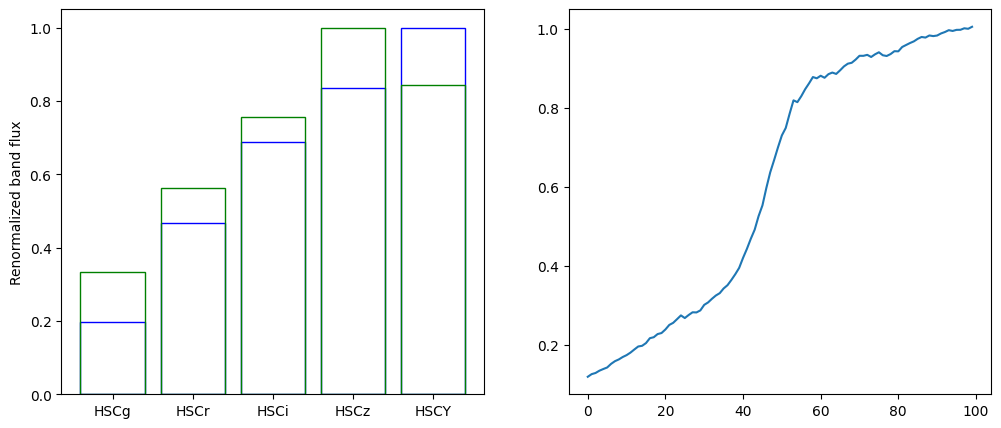

(<tf.Tensor: shape=(1, 16), dtype=float32, numpy=
array([[ 0.13674435, -0.01284186,  0.01338181,  0.00527511,  0.00490348,
         0.01277759, -0.00800836,  0.01259281,  0.01648714, -0.00829743,
         0.00472292, -0.00364414, -0.01058333, -0.02718791,  0.02848355,
         0.00963416]], dtype=float32)>, <tf.Tensor: shape=(1, 16), dtype=float32, numpy=
array([[-1.6349702e+00, -5.4035457e-03,  1.3683230e-02,  9.8626791e-03,
        -1.9493687e-03, -1.8194608e-02, -4.9999245e-03, -4.6447255e-03,
        -9.3006715e-03, -1.7551109e-02, -2.3838744e-02, -6.3096322e-03,
         6.0122684e-03,  4.9969763e-04, -4.3566470e+00, -4.9246773e-03]],
      dtype=float32)>, <tf.Tensor: shape=(1, 16), dtype=float32, numpy=
array([[ 0.46779418, -1.2224531 , -1.4171401 ,  0.7548746 , -0.9755741 ,
         0.04283559, -1.6584632 ,  1.5407702 , -1.3464061 ,  1.162364  ,
         0.02230352,  1.6173136 , -0.37552965,  0.19030914,  0.0608548 ,
         1.3139726 ]], dtype=float32)>, <tf.Tensor: shape=(1,

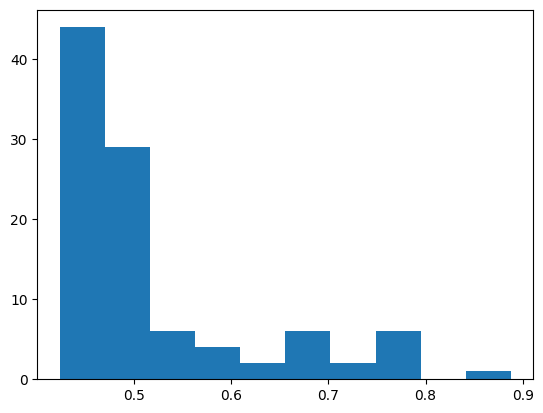

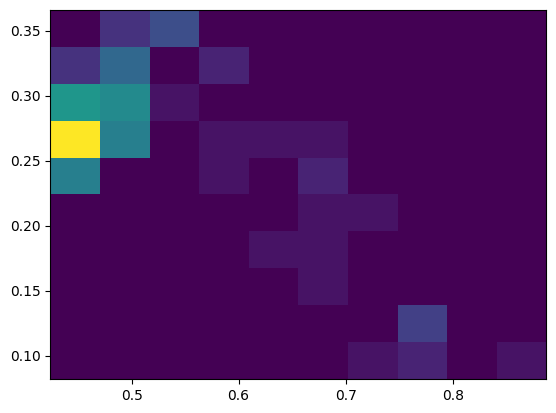

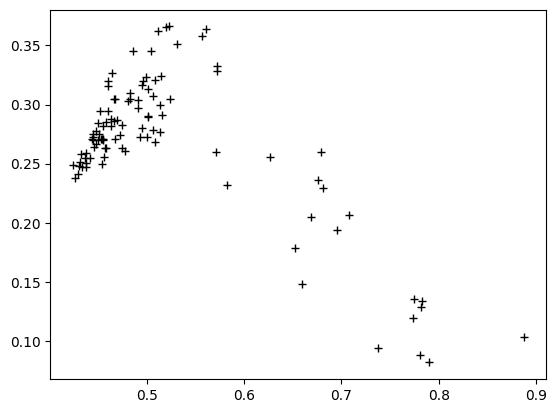

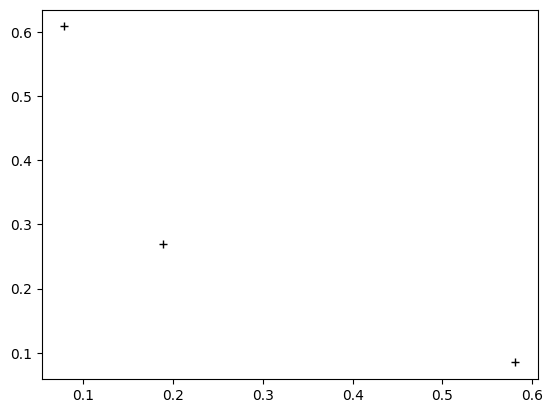

In [164]:
r = t_hsc[t_hsc['targetid'] == 39627761148494904][0]

ii = 50500

print(r)

mags = np.array([r['g_kronflux_mag'], r['r_kronflux_mag'], r['i_kronflux_mag'], r['z_kronflux_mag'], r['y_kronflux_mag']])
bandfl = 10**(-0.4*mags)

bandfl /= np.max(bandfl)

print(params[ii])

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(12, 5)
#axs[1].plot(wllr, spectra[ii], label="true spectrum")
#s = bpvae(np.reshape(bandfl, (1,5)))
#s = np.reshape(s[0].numpy(),(100,))
#axs[1].plot(wllr, s, label="spectrum from bandpasses")
#axs[1].set_xlabel('Wavelength, A')
axs[0].bar(filer_names, bandfl, fill=False, edgecolor='blue')
axs[0].bar(filer_names, integrals[ii], fill=False, edgecolor='green')
axs[0].set_ylabel('Renormalized band flux')
#fig.suptitle('z = %.2f' % (params[ii, 0]))

s = bpvae(np.reshape(bandfl, (1,5)))
s = np.reshape(s[0].numpy(),(100,))
axs[1].plot(s)

#plt.legend()
plt.show()

p_ls = parvae.apply(np.reshape(bandfl, (1,5)))


p = parvae(np.reshape(bandfl, (1,5)))

print(p_ls)

param_evals = []

nsmpl = 100
for i in range(nsmpl):
    p_ls = parvae(np.reshape(bandfl, (1,5)))
    param_evals.append(p_ls[0].numpy())

param_evals = np.array(param_evals)
plt.hist(param_evals[:, 0])
plt.show()


plt.hist2d(param_evals[:, 0], param_evals[:, 1])
plt.show()

plt.plot(param_evals[:, 0], param_evals[:, 1], 'k+')
plt.show()


rall = np.sum((integrals - bandfl)**2, axis=-1)

idx = np.where(rall < 5*0.01**2)[0]

p_v = params[idx]

plt.plot(p_v[:, 0], p_v[:, 1], 'k+')
plt.show()


In [165]:
#r = bpvae.apply(np.reshape(integrals[:80000],(80000,5,1)))
#corner_plot(r, max_params=16)


In [166]:
t_hsc[((t_hsc['z'] < 0.99) & (t_hsc['z'] > 0.8) & (t_hsc['z_photo'] < 0.4))]

object_id,ra,dec,g_kronflux_mag,r_kronflux_mag,i_kronflux_mag,z_kronflux_mag,y_kronflux_mag,z,mean_fiber_ra,targetid,tileid,zwarn,objid,specobjid,mjd,plate,fiberid,ra_2,dec_2,z_2,zerr,zconf,petror50_r,e_bv,specclass,corrmag_fuv,corrmag_nuv,corrmag_u,corrmag_g,corrmag_r,corrmag_i,corrmag_z,corrmag_y,corrmag_j,corrmag_h,corrmag_k,corrmag_fuv_err,corrmag_nuv_err,corrmag_u_err,corrmag_g_err,corrmag_r_err,corrmag_i_err,corrmag_z_err,corrmag_y_err,corrmag_j_err,corrmag_h_err,corrmag_k_err,kcorr_fuv,kcorr_nuv,kcorr_u,kcorr_g,kcorr_r,kcorr_i,kcorr_z,kcorr_y,kcorr_j,kcorr_h,kcorr_k,ssp_radvel,ssp_radvel_err,ssp_veldisp,ssp_veldisp_err,ssp_age,ssp_age_err,ssp_met,ssp_met_err,ssp_chi2,exp_radvel,exp_radvel_err,exp_veldisp,exp_veldisp_err,exp_tau,exp_tau_err,exp_met,exp_met_err,exp_chi2,zy_offset,spectrum_snr,Separation,z_photo
,,,,,,,,,deg,,,,,,d,,,deg,deg,,,,arcsec,mag,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,km / s,km / s,km / s,km / s,Myr,Myr,,,,km / s,km / s,km / s,km / s,Myr,Myr,,,,mag,,arcsec,
int64,float64,float64,float32,float32,float32,float32,float32,float64,float64,int64,int32,int64,int64,int64,int32,int16,int16,float64,float64,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float32
40687019763979855,36.796685273686336,-1.3248175280312515,23.539013,23.271015,22.765457,22.680986,22.549282,0.9160301052075265,36.79667230176699,39627755146446468,6364,0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,0.27367225
39631784954042200,39.59931935292315,-1.7745766064871369,22.683632,22.588284,22.307238,22.187729,21.828566,0.8848794318148275,39.59934410144945,39627743112989858,11064,0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,0.33297563
38562239313111195,39.223915324930566,-3.074773406332046,22.659092,22.514668,22.169994,22.116112,21.935478,0.8851809343679578,39.22393405671818,39627712905616616,9497,0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,0.28011918
38544926299936423,32.869712025993906,-2.9854951416353703,22.723381,22.54586,22.126762,22.039696,21.86779,0.9267206304397171,32.86969542155873,39627712800755782,11067,0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,0.26555485
38548899144668566,34.9512891930146,-3.508806909460553,23.394054,23.392063,22.840347,22.782171,22.878838,0.8816652821852067,34.95127332740822,39627700771493474,9489,0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,0.22539738
39604572041272757,31.852742517388112,-1.8334058073478743,19.748075,19.690037,19.65189,19.504513,19.558535,0.842868366641992,31.85275334542979,39627742982966903,1670,0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,0.100014

In [167]:
photoz_good = t_hsc[np.abs(t_hsc['z'] - t_hsc['z_photo']) < 0.15*(1 + t_hsc['z'])]
print(len(photoz_good), len(t_hsc), len(photoz_good)/len(t_hsc))

47476 111040 0.42755763688760806


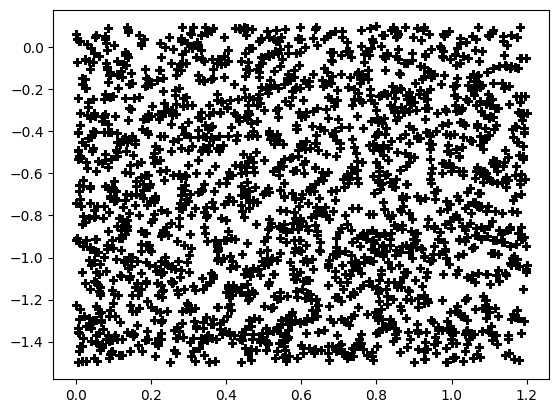

In [168]:
plt.plot(params[:, 0], params[:, 2], 'k+')
plt.show()